## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [2]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [3]:
import segmentation_models_pytorch as smp

In [4]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [5]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    backbone = 'efficientnet-b0'
    # backbone = 'se_resnext50_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 100 # 30

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'./{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [6]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [7]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [8]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [9]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [10]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [11]:
def read_image_mask(fragment_id):
    
    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [12]:
# def read_image_mask(fragment_id):
    
#     images = []
    
    
#     # take CFG.in_chans random idxs
#     idxs = np.random.choice(range(65), CFG.in_chans, replace=False)

#     for i in tqdm(idxs):
        
#         img_path = CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif"
#         print(img_path)
        
#         image = cv2.imread(img_path, 0)

#         pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
#         pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

#         image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

#         images.append(image)
#     images = np.stack(images, axis=2)

#     mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
#     mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

#     mask = mask.astype('float32')
#     mask /= 255.0
    
#     return images, mask

In [13]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [14]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [15]:
valid_xyxys = np.stack(valid_xyxys)

## dataset

In [16]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [17]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [18]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [19]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

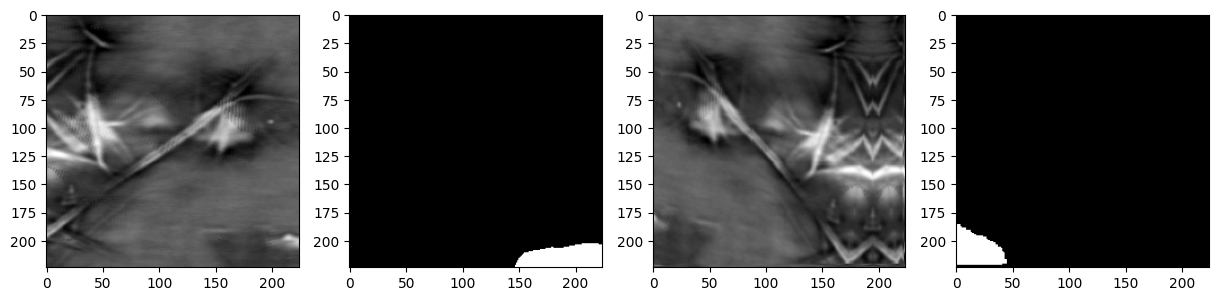

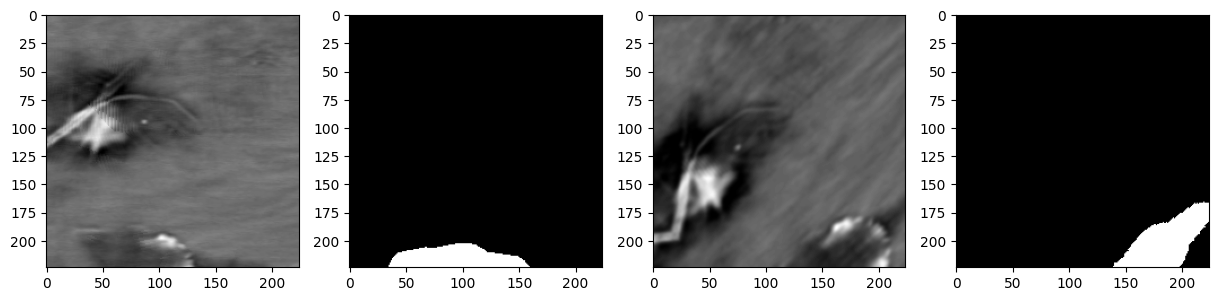

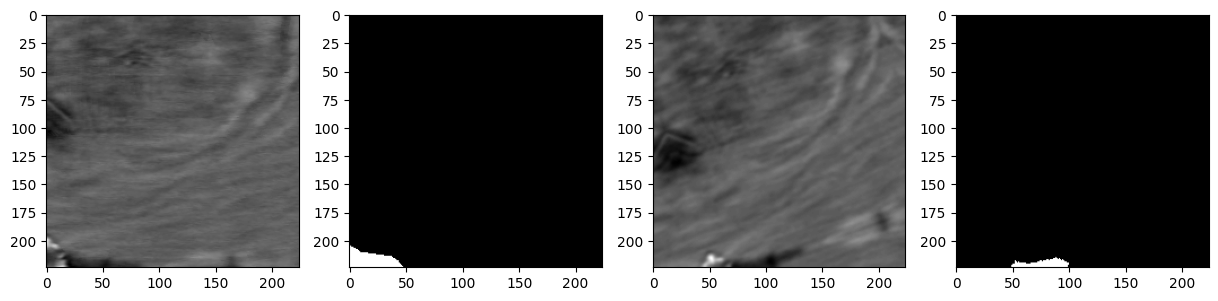

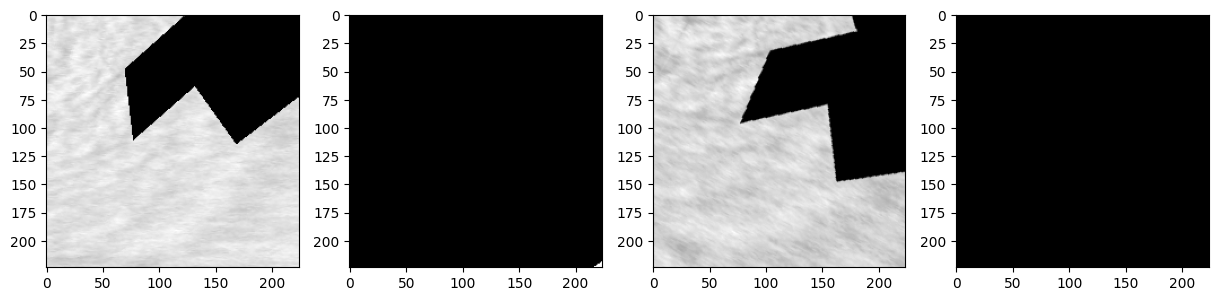

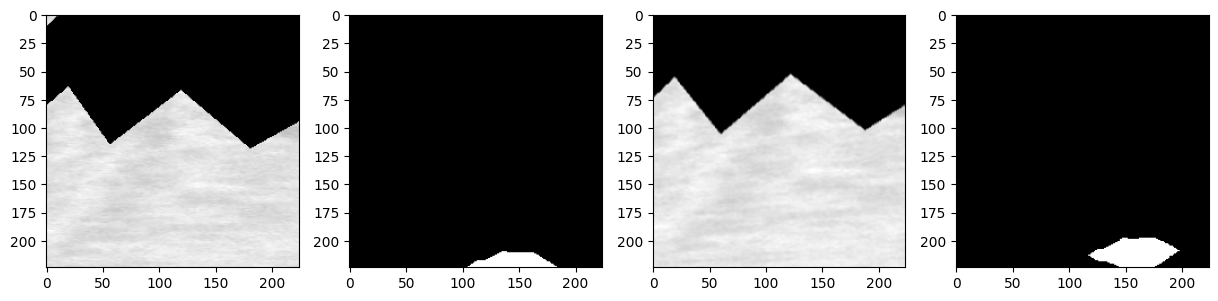

In [20]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [21]:
del plot_dataset
gc.collect()

53836

## model

In [22]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

## scheduler

In [23]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [24]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone efficientnet-b0


## loss

In [25]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    bce_loss =  BCELoss(y_pred, y_true)
    return bce_loss
    
    y_preds_probas = torch.sigmoid(y_pred)
    dxx = torch.pow(torch.roll(y_preds_probas, shifts=-1, dims=-1) - 2*y_preds_probas + torch.roll(y_preds_probas, shifts=1, dims=-2), 2)
    dyy = torch.pow(torch.roll(y_preds_probas, shifts=-1, dims=-2) - 2*y_preds_probas + torch.roll(y_preds_probas, shifts=1, dims=-2), 2)

    # Average over all pixels
    kin_energy = torch.mean(dxx + dyy)

    
    return bce_loss + kin_energy
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [26]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [27]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 100+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [28]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [29]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/home/viktor/miniconda3/envs/torch-env/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.12096148744953923
th: 0.15, fbeta: 0.12092508693473114
th: 0.2, fbeta: 0.12227844446935031
th: 0.25, fbeta: 0.20878007821830602
th: 0.3, fbeta: 0.22672197950470163
th: 0.35, fbeta: 0.23600805897180335
th: 0.4, fbeta: 0.23073366608466053
th: 0.45, fbeta: 0.20379351400199364
th: 0.5, fbeta: 0.13935144193113447
th: 0.55, fbeta: 0.06041232528274103
th: 0.6, fbeta: 0.017689688779486346
th: 0.65, fbeta: 0.004399505181173488
th: 0.7, fbeta: 0.0010591175793768768
th: 0.75, fbeta: 0.000236527633958163
th: 0.8, fbeta: 3.836630769832426e-05
th: 0.85, fbeta: 9.339676741231148e-07
th: 0.9, fbeta: 0.0
th: 0.95, fbeta: 0.0


best_th: 0.35, fbeta: 0.23600805897180335
Epoch 1 - avg_train_loss: 0.6188  avg_val_loss: 0.4179  time: 30s
Epoch 1 - avgScore: 0.2360
Epoch 1 - Save Best Score: 0.2360 Model
Epoch 1 - Save Best Loss: 0.4179 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.12171344296855391
th: 0.15, fbeta: 0.21617580407772788
th: 0.2, fbeta: 0.2516987184354925
th: 0.25, fbeta: 0.3010240395524247
th: 0.3, fbeta: 0.3487805670138951
th: 0.35, fbeta: 0.3784519587534365
th: 0.4, fbeta: 0.3756032776253869
th: 0.45, fbeta: 0.30754154491090524
th: 0.5, fbeta: 0.17334195244904255
th: 0.55, fbeta: 0.05168105468616036
th: 0.6, fbeta: 0.005723144241599609
th: 0.65, fbeta: 0.0003051668434979319
th: 0.7, fbeta: 7.491101084466411e-06
th: 0.75, fbeta: 0.0
th: 0.8, fbeta: 0.0
th: 0.85, fbeta: 0.0
th: 0.9, fbeta: 0.0
th: 0.95, fbeta: 0.0


best_th: 0.35, fbeta: 0.3784519587534365
Epoch 2 - avg_train_loss: 0.3911  avg_val_loss: 0.3224  time: 28s
Epoch 2 - avgScore: 0.3785
Epoch 2 - Save Best Score: 0.3785 Model
Epoch 2 - Save Best Loss: 0.3224 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/home/viktor/miniconda3/envs/torch-env/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


th: 0.1, fbeta: 0.3085529741478197
th: 0.15, fbeta: 0.34931321888895583
th: 0.2, fbeta: 0.38448015863088936
th: 0.25, fbeta: 0.41215898703734843
th: 0.3, fbeta: 0.433556626027673
th: 0.35, fbeta: 0.4357901974013549
th: 0.4, fbeta: 0.38011978554526954
th: 0.45, fbeta: 0.23800883053644015
th: 0.5, fbeta: 0.07178618796491441
th: 0.55, fbeta: 0.006487138495789623
th: 0.6, fbeta: 4.49456342649329e-05
th: 0.65, fbeta: 0.0
th: 0.7, fbeta: 0.0
th: 0.75, fbeta: 0.0
th: 0.8, fbeta: 0.0
th: 0.85, fbeta: 0.0
th: 0.9, fbeta: 0.0
th: 0.95, fbeta: 0.0


best_th: 0.35, fbeta: 0.4357901974013549
Epoch 3 - avg_train_loss: 0.2841  avg_val_loss: 0.2450  time: 28s
Epoch 3 - avgScore: 0.4358
Epoch 3 - Save Best Score: 0.4358 Model
Epoch 3 - Save Best Loss: 0.2450 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3309865152349997
th: 0.15, fbeta: 0.36343643788410224
th: 0.2, fbeta: 0.38737594280126036
th: 0.25, fbeta: 0.40246666559915256
th: 0.3, fbeta: 0.41134114278901607
th: 0.35, fbeta: 0.41348736873283287
th: 0.4, fbeta: 0.40874056108238016
th: 0.45, fbeta: 0.3923445062074321
th: 0.5, fbeta: 0.3610335276932885
th: 0.55, fbeta: 0.3093082442696782
th: 0.6, fbeta: 0.23544221226812043
th: 0.65, fbeta: 0.15518733873976728
th: 0.7, fbeta: 0.0677840753998458
th: 0.75, fbeta: 0.015805623853668817
th: 0.8, fbeta: 0.0018438648272353344
th: 0.85, fbeta: 0.0
th: 0.9, fbeta: 0.0
th: 0.95, fbeta: 0.0


best_th: 0.35, fbeta: 0.41348736873283287
Epoch 4 - avg_train_loss: 0.2527  avg_val_loss: 0.2413  time: 28s
Epoch 4 - avgScore: 0.4135


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3550087196944891
th: 0.15, fbeta: 0.40969144736376195
th: 0.2, fbeta: 0.43857402377088955
th: 0.25, fbeta: 0.45741623420669913
th: 0.3, fbeta: 0.4722613608574764
th: 0.35, fbeta: 0.48092057461163185
th: 0.4, fbeta: 0.4818876239659594
th: 0.45, fbeta: 0.47529100660368523
th: 0.5, fbeta: 0.45953432131035843
th: 0.55, fbeta: 0.43518869351491546
th: 0.6, fbeta: 0.3994878801250531
th: 0.65, fbeta: 0.3428049046868058
th: 0.7, fbeta: 0.25706505763615867
th: 0.75, fbeta: 0.1512271210175158
th: 0.8, fbeta: 0.05163568844104582
th: 0.85, fbeta: 0.010333615537590926
th: 0.9, fbeta: 0.0
th: 0.95, fbeta: 0.0


best_th: 0.4, fbeta: 0.4818876239659594
Epoch 5 - avg_train_loss: 0.2452  avg_val_loss: 0.2287  time: 28s
Epoch 5 - avgScore: 0.4819
Epoch 5 - Save Best Score: 0.4819 Model
Epoch 5 - Save Best Loss: 0.2287 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37180397452226804
th: 0.15, fbeta: 0.43645911395542925
th: 0.2, fbeta: 0.47668838058300234
th: 0.25, fbeta: 0.494199136224483
th: 0.3, fbeta: 0.5020736575253799
th: 0.35, fbeta: 0.5017854464136248
th: 0.4, fbeta: 0.49238734459042444
th: 0.45, fbeta: 0.47164500139815646
th: 0.5, fbeta: 0.4460278933130182
th: 0.55, fbeta: 0.4090657153551865
th: 0.6, fbeta: 0.3654320860211066
th: 0.65, fbeta: 0.3092249566293736
th: 0.7, fbeta: 0.2369493662349787
th: 0.75, fbeta: 0.1488837364630975
th: 0.8, fbeta: 0.05350788686936079
th: 0.85, fbeta: 0.0053983642485552225
th: 0.9, fbeta: 0.0
th: 0.95, fbeta: 0.0


best_th: 0.3, fbeta: 0.5020736575253799
Epoch 6 - avg_train_loss: 0.2388  avg_val_loss: 0.2386  time: 28s
Epoch 6 - avgScore: 0.5021
Epoch 6 - Save Best Score: 0.5021 Model
Epoch 6 - Save Best Loss: 0.2386 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39592904902703474
th: 0.15, fbeta: 0.4456776230714467
th: 0.2, fbeta: 0.4823675150766154
th: 0.25, fbeta: 0.5060661670943387
th: 0.3, fbeta: 0.5199438819244925
th: 0.35, fbeta: 0.5307165551848004
th: 0.4, fbeta: 0.5359026182380708
th: 0.45, fbeta: 0.5350097715799405
th: 0.5, fbeta: 0.5297467653154867
th: 0.55, fbeta: 0.5224256530387641
th: 0.6, fbeta: 0.5093791504288502
th: 0.65, fbeta: 0.4888546120875828
th: 0.7, fbeta: 0.45832643290226693
th: 0.75, fbeta: 0.41244884678856136
th: 0.8, fbeta: 0.3543028671440306
th: 0.85, fbeta: 0.28078410249872465
th: 0.9, fbeta: 0.17446618750187073
th: 0.95, fbeta: 0.04279055216308867


best_th: 0.4, fbeta: 0.5359026182380708
Epoch 7 - avg_train_loss: 0.2265  avg_val_loss: 0.2420  time: 28s
Epoch 7 - avgScore: 0.5359
Epoch 7 - Save Best Score: 0.5359 Model
Epoch 7 - Save Best Loss: 0.2420 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38730250246998305
th: 0.15, fbeta: 0.4434920656881026
th: 0.2, fbeta: 0.4731111782807819
th: 0.25, fbeta: 0.4736294515570968
th: 0.3, fbeta: 0.46534621746241844
th: 0.35, fbeta: 0.44433036403357895
th: 0.4, fbeta: 0.414424762590785
th: 0.45, fbeta: 0.3757640728050135
th: 0.5, fbeta: 0.33972635099333964
th: 0.55, fbeta: 0.30201052484434954
th: 0.6, fbeta: 0.2618769459956066
th: 0.65, fbeta: 0.21094600281412684
th: 0.7, fbeta: 0.150446077244357
th: 0.75, fbeta: 0.0921857392301686
th: 0.8, fbeta: 0.04831469967204845
th: 0.85, fbeta: 0.017745869922402128
th: 0.9, fbeta: 0.0009908657755141206
th: 0.95, fbeta: 0.0


best_th: 0.25, fbeta: 0.4736294515570968
Epoch 8 - avg_train_loss: 0.2263  avg_val_loss: 0.2530  time: 28s
Epoch 8 - avgScore: 0.4736


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.415088347271588
th: 0.15, fbeta: 0.4445411370573739
th: 0.2, fbeta: 0.4694204608902503
th: 0.25, fbeta: 0.488345539900131
th: 0.3, fbeta: 0.5051899888544554
th: 0.35, fbeta: 0.5127220185321426
th: 0.4, fbeta: 0.5113771483973946
th: 0.45, fbeta: 0.5040343128540041
th: 0.5, fbeta: 0.4872451633340199
th: 0.55, fbeta: 0.46286105026632696
th: 0.6, fbeta: 0.43288307952411503
th: 0.65, fbeta: 0.3931293749873569
th: 0.7, fbeta: 0.34403297129761806
th: 0.75, fbeta: 0.2837613192776711
th: 0.8, fbeta: 0.20414582562919403
th: 0.85, fbeta: 0.11799717566318868
th: 0.9, fbeta: 0.039340931386980235
th: 0.95, fbeta: 0.00018725274768451264


best_th: 0.35, fbeta: 0.5127220185321426
Epoch 9 - avg_train_loss: 0.2164  avg_val_loss: 0.2642  time: 28s
Epoch 9 - avgScore: 0.5127


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4492892419444768
th: 0.15, fbeta: 0.46820688228718854
th: 0.2, fbeta: 0.4760473204292683
th: 0.25, fbeta: 0.4751154014740404
th: 0.3, fbeta: 0.47243814073094526
th: 0.35, fbeta: 0.46499826982251086
th: 0.4, fbeta: 0.45152874189666137
th: 0.45, fbeta: 0.43581308522479045
th: 0.5, fbeta: 0.4129317928073086
th: 0.55, fbeta: 0.3866301462663852
th: 0.6, fbeta: 0.35831867184259275
th: 0.65, fbeta: 0.32379336057458746
th: 0.7, fbeta: 0.2822567883077163
th: 0.75, fbeta: 0.2312134223741232
th: 0.8, fbeta: 0.17464653941579467
th: 0.85, fbeta: 0.10448797642099428
th: 0.9, fbeta: 0.040943623866889566
th: 0.95, fbeta: 0.003879616453952134


best_th: 0.2, fbeta: 0.4760473204292683
Epoch 10 - avg_train_loss: 0.2115  avg_val_loss: 0.2867  time: 28s
Epoch 10 - avgScore: 0.4760


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3649979916681802
th: 0.15, fbeta: 0.3965594055594214
th: 0.2, fbeta: 0.41866143944392664
th: 0.25, fbeta: 0.43998696039147106
th: 0.3, fbeta: 0.4599229417558953
th: 0.35, fbeta: 0.47848555692368766
th: 0.4, fbeta: 0.4975835917387551
th: 0.45, fbeta: 0.5104939414068621
th: 0.5, fbeta: 0.5189473107371023
th: 0.55, fbeta: 0.5234411587948156
th: 0.6, fbeta: 0.5229290459384226
th: 0.65, fbeta: 0.5139401458316232
th: 0.7, fbeta: 0.4924414558624771
th: 0.75, fbeta: 0.453881575117096
th: 0.8, fbeta: 0.3968319994699333
th: 0.85, fbeta: 0.30967710266909554
th: 0.9, fbeta: 0.18534280196071742
th: 0.95, fbeta: 0.044352286048888544


best_th: 0.55, fbeta: 0.5234411587948156
Epoch 11 - avg_train_loss: 0.2071  avg_val_loss: 0.2406  time: 28s
Epoch 11 - avgScore: 0.5234


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.44002168397870856
th: 0.15, fbeta: 0.47070525711853517
th: 0.2, fbeta: 0.48967110968997357
th: 0.25, fbeta: 0.5043077405102084
th: 0.3, fbeta: 0.5090721332601275
th: 0.35, fbeta: 0.5035922364755446
th: 0.4, fbeta: 0.48833330549079207
th: 0.45, fbeta: 0.46420690651906815
th: 0.5, fbeta: 0.43693891271863966
th: 0.55, fbeta: 0.4058345516468026
th: 0.6, fbeta: 0.3697389979046506
th: 0.65, fbeta: 0.3319346797023815
th: 0.7, fbeta: 0.2913370535736774
th: 0.75, fbeta: 0.24801869918759387
th: 0.8, fbeta: 0.19923370345483818
th: 0.85, fbeta: 0.14178371255019262
th: 0.9, fbeta: 0.0805939782253893
th: 0.95, fbeta: 0.019686336998542334


best_th: 0.3, fbeta: 0.5090721332601275
Epoch 12 - avg_train_loss: 0.2018  avg_val_loss: 0.2893  time: 28s
Epoch 12 - avgScore: 0.5091


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4340722737997514
th: 0.15, fbeta: 0.4650617547847689
th: 0.2, fbeta: 0.48823093993409766
th: 0.25, fbeta: 0.5010441535250274
th: 0.3, fbeta: 0.5097236886465696
th: 0.35, fbeta: 0.511825679609809
th: 0.4, fbeta: 0.5097441795164543
th: 0.45, fbeta: 0.4974413789075701
th: 0.5, fbeta: 0.47505890365788894
th: 0.55, fbeta: 0.4467116117693996
th: 0.6, fbeta: 0.41699508635066634
th: 0.65, fbeta: 0.38135307352563375
th: 0.7, fbeta: 0.3376416104126457
th: 0.75, fbeta: 0.28354558625990967
th: 0.8, fbeta: 0.22533405348265098
th: 0.85, fbeta: 0.1540912716890925
th: 0.9, fbeta: 0.0693507226480402
th: 0.95, fbeta: 0.010984609862345528


best_th: 0.35, fbeta: 0.511825679609809
Epoch 13 - avg_train_loss: 0.1984  avg_val_loss: 0.2788  time: 28s
Epoch 13 - avgScore: 0.5118


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4239542147765915
th: 0.15, fbeta: 0.4519312026118764
th: 0.2, fbeta: 0.4715553521423729
th: 0.25, fbeta: 0.4804144116462197
th: 0.3, fbeta: 0.48578814828730005
th: 0.35, fbeta: 0.4864181015141957
th: 0.4, fbeta: 0.48010186585341313
th: 0.45, fbeta: 0.46696611119803344
th: 0.5, fbeta: 0.45115742209916104
th: 0.55, fbeta: 0.4304196363938031
th: 0.6, fbeta: 0.4006012503429757
th: 0.65, fbeta: 0.36315545092685086
th: 0.7, fbeta: 0.3190040577862673
th: 0.75, fbeta: 0.2641958790900058
th: 0.8, fbeta: 0.2046426928460854
th: 0.85, fbeta: 0.13690182326771544
th: 0.9, fbeta: 0.06643762720126971
th: 0.95, fbeta: 0.009063738033328269


best_th: 0.35, fbeta: 0.4864181015141957
Epoch 14 - avg_train_loss: 0.1932  avg_val_loss: 0.2897  time: 28s
Epoch 14 - avgScore: 0.4864


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.43111036578630546
th: 0.15, fbeta: 0.46159624421034756
th: 0.2, fbeta: 0.483632194628068
th: 0.25, fbeta: 0.4969955534400066
th: 0.3, fbeta: 0.5025056480629276
th: 0.35, fbeta: 0.504382689942592
th: 0.4, fbeta: 0.5019821362973936
th: 0.45, fbeta: 0.4952741152793751
th: 0.5, fbeta: 0.48191128413021567
th: 0.55, fbeta: 0.4604166003159827
th: 0.6, fbeta: 0.431660956910739
th: 0.65, fbeta: 0.3963183541107116
th: 0.7, fbeta: 0.3571909328302511
th: 0.75, fbeta: 0.31489151918234515
th: 0.8, fbeta: 0.2670458972769487
th: 0.85, fbeta: 0.20931781069674338
th: 0.9, fbeta: 0.14046617452640486
th: 0.95, fbeta: 0.046962685152814154


best_th: 0.35, fbeta: 0.504382689942592
Epoch 15 - avg_train_loss: 0.1895  avg_val_loss: 0.2805  time: 28s
Epoch 15 - avgScore: 0.5044


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32333755577112244
th: 0.15, fbeta: 0.34194948210425385
th: 0.2, fbeta: 0.3592806438717942
th: 0.25, fbeta: 0.37569669234563047
th: 0.3, fbeta: 0.3905408611715693
th: 0.35, fbeta: 0.4063907254928554
th: 0.4, fbeta: 0.42287116736434444
th: 0.45, fbeta: 0.43741128565079895
th: 0.5, fbeta: 0.44875919640063056
th: 0.55, fbeta: 0.4587151871978808
th: 0.6, fbeta: 0.46703816580549545
th: 0.65, fbeta: 0.47493118168383847
th: 0.7, fbeta: 0.47326988045214174
th: 0.75, fbeta: 0.46334891608630746
th: 0.8, fbeta: 0.44039576650090456
th: 0.85, fbeta: 0.3907981041822534
th: 0.9, fbeta: 0.3148313784484089
th: 0.95, fbeta: 0.15813490493860918


best_th: 0.65, fbeta: 0.47493118168383847
Epoch 16 - avg_train_loss: 0.1844  avg_val_loss: 0.2789  time: 28s
Epoch 16 - avgScore: 0.4749


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4054649951930881
th: 0.15, fbeta: 0.44683611559231945
th: 0.2, fbeta: 0.4784862629240661
th: 0.25, fbeta: 0.5008409605761418
th: 0.3, fbeta: 0.518901306212966
th: 0.35, fbeta: 0.5303069513684054
th: 0.4, fbeta: 0.5393995226387026
th: 0.45, fbeta: 0.5450461555131073
th: 0.5, fbeta: 0.5467371174505868
th: 0.55, fbeta: 0.5413165840125305
th: 0.6, fbeta: 0.5289613439545042
th: 0.65, fbeta: 0.5105057542493142
th: 0.7, fbeta: 0.4847135256180376
th: 0.75, fbeta: 0.4521166427931507
th: 0.8, fbeta: 0.4093082340067537
th: 0.85, fbeta: 0.34836294014936214
th: 0.9, fbeta: 0.2611664028297816
th: 0.95, fbeta: 0.12686535405604643


best_th: 0.5, fbeta: 0.5467371174505868
Epoch 17 - avg_train_loss: 0.1851  avg_val_loss: 0.2331  time: 29s
Epoch 17 - avgScore: 0.5467
Epoch 17 - Save Best Score: 0.5467 Model
Epoch 17 - Save Best Loss: 0.2331 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4213087665893131
th: 0.15, fbeta: 0.4569044564722464
th: 0.2, fbeta: 0.48753405775912884
th: 0.25, fbeta: 0.5101629095973634
th: 0.3, fbeta: 0.5254503202781382
th: 0.35, fbeta: 0.5343929036692386
th: 0.4, fbeta: 0.5429777992638153
th: 0.45, fbeta: 0.5454040785984587
th: 0.5, fbeta: 0.538367520992396
th: 0.55, fbeta: 0.5260251330092137
th: 0.6, fbeta: 0.5076220751819794
th: 0.65, fbeta: 0.4832191213296423
th: 0.7, fbeta: 0.4480277932559603
th: 0.75, fbeta: 0.4043628941839539
th: 0.8, fbeta: 0.3447171581629816
th: 0.85, fbeta: 0.26148755850689837
th: 0.9, fbeta: 0.15386024674527368
th: 0.95, fbeta: 0.034094953393034595


best_th: 0.45, fbeta: 0.5454040785984587
Epoch 18 - avg_train_loss: 0.1741  avg_val_loss: 0.2432  time: 28s
Epoch 18 - avgScore: 0.5454


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4879350786725507
th: 0.15, fbeta: 0.510739396570197
th: 0.2, fbeta: 0.5184600099848302
th: 0.25, fbeta: 0.5139082668652925
th: 0.3, fbeta: 0.5027723198286197
th: 0.35, fbeta: 0.48706635987736474
th: 0.4, fbeta: 0.46188370400372813
th: 0.45, fbeta: 0.43152579486572934
th: 0.5, fbeta: 0.39663802469582443
th: 0.55, fbeta: 0.3584706475160346
th: 0.6, fbeta: 0.32077518288963924
th: 0.65, fbeta: 0.2811187024826978
th: 0.7, fbeta: 0.23367248675756902
th: 0.75, fbeta: 0.18137317875639036
th: 0.8, fbeta: 0.12835447949253886
th: 0.85, fbeta: 0.07325583506132971
th: 0.9, fbeta: 0.03358431261209562
th: 0.95, fbeta: 0.00995182921800399


best_th: 0.2, fbeta: 0.5184600099848302
Epoch 19 - avg_train_loss: 0.1706  avg_val_loss: 0.2882  time: 28s
Epoch 19 - avgScore: 0.5185


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42048401144907266
th: 0.15, fbeta: 0.4496611330837254
th: 0.2, fbeta: 0.4713229070321804
th: 0.25, fbeta: 0.4851220883541982
th: 0.3, fbeta: 0.49285695917361383
th: 0.35, fbeta: 0.49770299399450524
th: 0.4, fbeta: 0.5006411356861314
th: 0.45, fbeta: 0.49671741578909967
th: 0.5, fbeta: 0.49116626960102916
th: 0.55, fbeta: 0.4789234651631102
th: 0.6, fbeta: 0.46140674964767225
th: 0.65, fbeta: 0.434948786087628
th: 0.7, fbeta: 0.40487449115726215
th: 0.75, fbeta: 0.3687507899307439
th: 0.8, fbeta: 0.3285694398400082
th: 0.85, fbeta: 0.2803569247022705
th: 0.9, fbeta: 0.2127992539162985
th: 0.95, fbeta: 0.10812867186602389


best_th: 0.4, fbeta: 0.5006411356861314
Epoch 20 - avg_train_loss: 0.1674  avg_val_loss: 0.2753  time: 29s
Epoch 20 - avgScore: 0.5006


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4367586300853222
th: 0.15, fbeta: 0.4627245766759488
th: 0.2, fbeta: 0.48220706038254324
th: 0.25, fbeta: 0.49308284762155985
th: 0.3, fbeta: 0.5002349462850809
th: 0.35, fbeta: 0.5061482354194555
th: 0.4, fbeta: 0.5094684710573181
th: 0.45, fbeta: 0.5087939182367823
th: 0.5, fbeta: 0.5013307617699996
th: 0.55, fbeta: 0.4879378819374512
th: 0.6, fbeta: 0.4723508688220779
th: 0.65, fbeta: 0.4518219589011377
th: 0.7, fbeta: 0.4250011736827302
th: 0.75, fbeta: 0.395298792424678
th: 0.8, fbeta: 0.35703501649092256
th: 0.85, fbeta: 0.30903220511671764
th: 0.9, fbeta: 0.24465966876944903
th: 0.95, fbeta: 0.14546531537886268


best_th: 0.4, fbeta: 0.5094684710573181
Epoch 21 - avg_train_loss: 0.1634  avg_val_loss: 0.2819  time: 28s
Epoch 21 - avgScore: 0.5095


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42522008023497676
th: 0.15, fbeta: 0.4577526343858598
th: 0.2, fbeta: 0.481694026684089
th: 0.25, fbeta: 0.49925014214029234
th: 0.3, fbeta: 0.5106364974242913
th: 0.35, fbeta: 0.5138121262043402
th: 0.4, fbeta: 0.5156790924335587
th: 0.45, fbeta: 0.509365515405303
th: 0.5, fbeta: 0.49717857060241927
th: 0.55, fbeta: 0.48022517961820615
th: 0.6, fbeta: 0.4601172237473512
th: 0.65, fbeta: 0.4329058229768073
th: 0.7, fbeta: 0.3907108176326429
th: 0.75, fbeta: 0.34114266601838245
th: 0.8, fbeta: 0.2835661076113383
th: 0.85, fbeta: 0.21146554652327973
th: 0.9, fbeta: 0.11235071808116026
th: 0.95, fbeta: 0.01615494976113164


best_th: 0.4, fbeta: 0.5156790924335587
Epoch 22 - avg_train_loss: 0.1640  avg_val_loss: 0.2707  time: 28s
Epoch 22 - avgScore: 0.5157


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4466388454891794
th: 0.15, fbeta: 0.4672829152592121
th: 0.2, fbeta: 0.47562251143858203
th: 0.25, fbeta: 0.47797716341563395
th: 0.3, fbeta: 0.47360362990260724
th: 0.35, fbeta: 0.46078721959059926
th: 0.4, fbeta: 0.4446567923849598
th: 0.45, fbeta: 0.4284770631171931
th: 0.5, fbeta: 0.4104417192922957
th: 0.55, fbeta: 0.3842019123826496
th: 0.6, fbeta: 0.35540158820203943
th: 0.65, fbeta: 0.3249768619463531
th: 0.7, fbeta: 0.29219650325906293
th: 0.75, fbeta: 0.2578990807034279
th: 0.8, fbeta: 0.2174750291851926
th: 0.85, fbeta: 0.1690162739303057
th: 0.9, fbeta: 0.10943971588743263
th: 0.95, fbeta: 0.03565572427289735


best_th: 0.25, fbeta: 0.47797716341563395
Epoch 23 - avg_train_loss: 0.1603  avg_val_loss: 0.2916  time: 28s
Epoch 23 - avgScore: 0.4780


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4117823398702479
th: 0.15, fbeta: 0.44547004344091923
th: 0.2, fbeta: 0.4653825937689041
th: 0.25, fbeta: 0.48108559181521104
th: 0.3, fbeta: 0.49470667917835803
th: 0.35, fbeta: 0.5037536967483672
th: 0.4, fbeta: 0.5096193965485253
th: 0.45, fbeta: 0.5124062611642233
th: 0.5, fbeta: 0.5082679403999082
th: 0.55, fbeta: 0.49854915815478146
th: 0.6, fbeta: 0.48638779949122807
th: 0.65, fbeta: 0.47285912635725813
th: 0.7, fbeta: 0.45477009205595054
th: 0.75, fbeta: 0.43300738793832716
th: 0.8, fbeta: 0.3994607950753098
th: 0.85, fbeta: 0.3485031256387429
th: 0.9, fbeta: 0.26905238320644453
th: 0.95, fbeta: 0.14000431987063555


best_th: 0.45, fbeta: 0.5124062611642233
Epoch 24 - avg_train_loss: 0.1503  avg_val_loss: 0.2692  time: 28s
Epoch 24 - avgScore: 0.5124


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42251644098308555
th: 0.15, fbeta: 0.4571037576138122
th: 0.2, fbeta: 0.4831346343971163
th: 0.25, fbeta: 0.4993893898940183
th: 0.3, fbeta: 0.5092164490813086
th: 0.35, fbeta: 0.5107256590374255
th: 0.4, fbeta: 0.51211957917846
th: 0.45, fbeta: 0.5040171100623092
th: 0.5, fbeta: 0.4913635786019229
th: 0.55, fbeta: 0.4779004616992319
th: 0.6, fbeta: 0.4623399896670895
th: 0.65, fbeta: 0.4455701080993666
th: 0.7, fbeta: 0.425758569630673
th: 0.75, fbeta: 0.3944206719334903
th: 0.8, fbeta: 0.3492363573283498
th: 0.85, fbeta: 0.28635071708274457
th: 0.9, fbeta: 0.2026637909865815
th: 0.95, fbeta: 0.08326277885416752


best_th: 0.4, fbeta: 0.51211957917846
Epoch 25 - avg_train_loss: 0.1490  avg_val_loss: 0.2708  time: 28s
Epoch 25 - avgScore: 0.5121


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42550052695000573
th: 0.15, fbeta: 0.4483190020830931
th: 0.2, fbeta: 0.467088174784935
th: 0.25, fbeta: 0.4785256523882032
th: 0.3, fbeta: 0.4816579920556628
th: 0.35, fbeta: 0.4762555616987969
th: 0.4, fbeta: 0.46342201066534283
th: 0.45, fbeta: 0.4498786351288105
th: 0.5, fbeta: 0.4335794043835294
th: 0.55, fbeta: 0.4159939544494442
th: 0.6, fbeta: 0.3930565520615197
th: 0.65, fbeta: 0.3654267919299265
th: 0.7, fbeta: 0.3273995641942759
th: 0.75, fbeta: 0.287062251066639
th: 0.8, fbeta: 0.23818442124258474
th: 0.85, fbeta: 0.18425923604174793
th: 0.9, fbeta: 0.12359033108068619
th: 0.95, fbeta: 0.047234228185589255


best_th: 0.3, fbeta: 0.4816579920556628
Epoch 26 - avg_train_loss: 0.1455  avg_val_loss: 0.3291  time: 28s
Epoch 26 - avgScore: 0.4817


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.45844471240181955
th: 0.15, fbeta: 0.48007035118166763
th: 0.2, fbeta: 0.48984489525462993
th: 0.25, fbeta: 0.4909535348304758
th: 0.3, fbeta: 0.4878396974764125
th: 0.35, fbeta: 0.47841863127575696
th: 0.4, fbeta: 0.4638016264730777
th: 0.45, fbeta: 0.4436240926073347
th: 0.5, fbeta: 0.42054341270896956
th: 0.55, fbeta: 0.39417988734999215
th: 0.6, fbeta: 0.3661011863856561
th: 0.65, fbeta: 0.3345706826605154
th: 0.7, fbeta: 0.3029035034056907
th: 0.75, fbeta: 0.2671744622018962
th: 0.8, fbeta: 0.22739199646388233
th: 0.85, fbeta: 0.18378792627898177
th: 0.9, fbeta: 0.12912710812819653
th: 0.95, fbeta: 0.058361554674531226


best_th: 0.25, fbeta: 0.4909535348304758
Epoch 27 - avg_train_loss: 0.1504  avg_val_loss: 0.3271  time: 29s
Epoch 27 - avgScore: 0.4910


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4362256344780741
th: 0.15, fbeta: 0.4601754297036834
th: 0.2, fbeta: 0.47992184777884866
th: 0.25, fbeta: 0.4950134212640021
th: 0.3, fbeta: 0.5015199584079979
th: 0.35, fbeta: 0.5047934938473162
th: 0.4, fbeta: 0.5072402831663215
th: 0.45, fbeta: 0.5044470175268454
th: 0.5, fbeta: 0.49666127734617943
th: 0.55, fbeta: 0.48559512585008524
th: 0.6, fbeta: 0.4708067250485961
th: 0.65, fbeta: 0.45065308251543673
th: 0.7, fbeta: 0.4229764367254145
th: 0.75, fbeta: 0.3868575038372485
th: 0.8, fbeta: 0.3392678865891143
th: 0.85, fbeta: 0.2781949184211258
th: 0.9, fbeta: 0.19779176473826054
th: 0.95, fbeta: 0.07858161165736388


best_th: 0.4, fbeta: 0.5072402831663215
Epoch 28 - avg_train_loss: 0.1432  avg_val_loss: 0.3031  time: 28s
Epoch 28 - avgScore: 0.5072


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.44460933284090914
th: 0.15, fbeta: 0.46903216740499637
th: 0.2, fbeta: 0.4874553842235229
th: 0.25, fbeta: 0.4962019886868547
th: 0.3, fbeta: 0.4983036770305102
th: 0.35, fbeta: 0.49590972239916187
th: 0.4, fbeta: 0.4891517813902419
th: 0.45, fbeta: 0.4771722905179954
th: 0.5, fbeta: 0.46258735898484615
th: 0.55, fbeta: 0.4445285697408307
th: 0.6, fbeta: 0.4244084229656551
th: 0.65, fbeta: 0.40143180722636507
th: 0.7, fbeta: 0.37500692600585095
th: 0.75, fbeta: 0.34531129192210436
th: 0.8, fbeta: 0.3076069921153308
th: 0.85, fbeta: 0.25802705708319273
th: 0.9, fbeta: 0.19987400712760844
th: 0.95, fbeta: 0.11185440067251096


best_th: 0.3, fbeta: 0.4983036770305102
Epoch 29 - avg_train_loss: 0.1388  avg_val_loss: 0.3397  time: 28s
Epoch 29 - avgScore: 0.4983


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.46495834626403026
th: 0.15, fbeta: 0.4978943538753624
th: 0.2, fbeta: 0.5212101807250742
th: 0.25, fbeta: 0.5407992073501336
th: 0.3, fbeta: 0.5510791016249335
th: 0.35, fbeta: 0.5531399005135179
th: 0.4, fbeta: 0.549964589662482
th: 0.45, fbeta: 0.5433464445879028
th: 0.5, fbeta: 0.5335977877085716
th: 0.55, fbeta: 0.5217808481601629
th: 0.6, fbeta: 0.5064829346825581
th: 0.65, fbeta: 0.4882455996242394
th: 0.7, fbeta: 0.4675143844191799
th: 0.75, fbeta: 0.43935140691249724
th: 0.8, fbeta: 0.404033218527085
th: 0.85, fbeta: 0.35633555893150404
th: 0.9, fbeta: 0.2916552281500359
th: 0.95, fbeta: 0.18548011980093915


best_th: 0.35, fbeta: 0.5531399005135179
Epoch 30 - avg_train_loss: 0.1342  avg_val_loss: 0.2941  time: 29s
Epoch 30 - avgScore: 0.5531
Epoch 30 - Save Best Score: 0.5531 Model
Epoch 30 - Save Best Loss: 0.2941 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4581513028479285
th: 0.15, fbeta: 0.4761788972632682
th: 0.2, fbeta: 0.4946680827381686
th: 0.25, fbeta: 0.5040444911186814
th: 0.3, fbeta: 0.5083185821818225
th: 0.35, fbeta: 0.508820656451965
th: 0.4, fbeta: 0.5066297557324112
th: 0.45, fbeta: 0.5003956141844262
th: 0.5, fbeta: 0.49182693911864944
th: 0.55, fbeta: 0.48216576419572504
th: 0.6, fbeta: 0.47211270983479253
th: 0.65, fbeta: 0.4574109272062618
th: 0.7, fbeta: 0.43602700079267026
th: 0.75, fbeta: 0.40677763394210004
th: 0.8, fbeta: 0.3725116809940409
th: 0.85, fbeta: 0.3319894818635914
th: 0.9, fbeta: 0.2779706383410454
th: 0.95, fbeta: 0.18714503907314883


best_th: 0.35, fbeta: 0.508820656451965
Epoch 31 - avg_train_loss: 0.1332  avg_val_loss: 0.3223  time: 28s
Epoch 31 - avgScore: 0.5088


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.41449054318362005
th: 0.15, fbeta: 0.44902794221674386
th: 0.2, fbeta: 0.47535750489887013
th: 0.25, fbeta: 0.4956217156087763
th: 0.3, fbeta: 0.50939871851675
th: 0.35, fbeta: 0.5172589655634414
th: 0.4, fbeta: 0.5231436489766602
th: 0.45, fbeta: 0.5237289457921811
th: 0.5, fbeta: 0.5178925040143466
th: 0.55, fbeta: 0.508627079084858
th: 0.6, fbeta: 0.49567671717117257
th: 0.65, fbeta: 0.4802620920467178
th: 0.7, fbeta: 0.45909900192151937
th: 0.75, fbeta: 0.4321939885375957
th: 0.8, fbeta: 0.39840387174960384
th: 0.85, fbeta: 0.352589804227527
th: 0.9, fbeta: 0.2866296711199059
th: 0.95, fbeta: 0.1825701377688308


best_th: 0.45, fbeta: 0.5237289457921811
Epoch 32 - avg_train_loss: 0.1330  avg_val_loss: 0.2848  time: 28s
Epoch 32 - avgScore: 0.5237


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4441230085565192
th: 0.15, fbeta: 0.46919808994270296
th: 0.2, fbeta: 0.4853007466045474
th: 0.25, fbeta: 0.49592644535816255
th: 0.3, fbeta: 0.4968870436509204
th: 0.35, fbeta: 0.49494677009351423
th: 0.4, fbeta: 0.4879858700561035
th: 0.45, fbeta: 0.47714668751795825
th: 0.5, fbeta: 0.46512340318709305
th: 0.55, fbeta: 0.4507281314574992
th: 0.6, fbeta: 0.4330777498353164
th: 0.65, fbeta: 0.41094005665593675
th: 0.7, fbeta: 0.38448511878910707
th: 0.75, fbeta: 0.3551636035508434
th: 0.8, fbeta: 0.31813723197143245
th: 0.85, fbeta: 0.26974982686755505
th: 0.9, fbeta: 0.20505548223135542
th: 0.95, fbeta: 0.10591301108614852


best_th: 0.3, fbeta: 0.4968870436509204
Epoch 33 - avg_train_loss: 0.1287  avg_val_loss: 0.3236  time: 28s
Epoch 33 - avgScore: 0.4969


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.47715756804443643
th: 0.15, fbeta: 0.5026386839646286
th: 0.2, fbeta: 0.5185168342124337
th: 0.25, fbeta: 0.5276205119704399
th: 0.3, fbeta: 0.5300330910391421
th: 0.35, fbeta: 0.5276855928118996
th: 0.4, fbeta: 0.5242666100320359
th: 0.45, fbeta: 0.5151930098246625
th: 0.5, fbeta: 0.5042045771475837
th: 0.55, fbeta: 0.49158097331388817
th: 0.6, fbeta: 0.47603930254935645
th: 0.65, fbeta: 0.45649201388283744
th: 0.7, fbeta: 0.431633809785941
th: 0.75, fbeta: 0.3969547320134964
th: 0.8, fbeta: 0.3550649137560115
th: 0.85, fbeta: 0.29712170288450257
th: 0.9, fbeta: 0.22060091496302836
th: 0.95, fbeta: 0.10666676145343641


best_th: 0.3, fbeta: 0.5300330910391421
Epoch 34 - avg_train_loss: 0.1294  avg_val_loss: 0.3279  time: 28s
Epoch 34 - avgScore: 0.5300


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.47464493186405826
th: 0.15, fbeta: 0.49818455722558613
th: 0.2, fbeta: 0.5080177777189611
th: 0.25, fbeta: 0.5141890824835957
th: 0.3, fbeta: 0.5161201567228818
th: 0.35, fbeta: 0.5101199468758172
th: 0.4, fbeta: 0.500026024217936
th: 0.45, fbeta: 0.48772106192423526
th: 0.5, fbeta: 0.4740751911912748
th: 0.55, fbeta: 0.4573136523854438
th: 0.6, fbeta: 0.43608530209258245
th: 0.65, fbeta: 0.4109423612147705
th: 0.7, fbeta: 0.38188199202582335
th: 0.75, fbeta: 0.3495324803544011
th: 0.8, fbeta: 0.31335393286701335
th: 0.85, fbeta: 0.269436392718888
th: 0.9, fbeta: 0.20172839428066688
th: 0.95, fbeta: 0.10737419604907972


best_th: 0.3, fbeta: 0.5161201567228818
Epoch 35 - avg_train_loss: 0.1259  avg_val_loss: 0.3214  time: 28s
Epoch 35 - avgScore: 0.5161


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.446263647118456
th: 0.15, fbeta: 0.4719181050870135
th: 0.2, fbeta: 0.49066161076746634
th: 0.25, fbeta: 0.5056134884571063
th: 0.3, fbeta: 0.5161215471224824
th: 0.35, fbeta: 0.517152052167845
th: 0.4, fbeta: 0.5141189481391735
th: 0.45, fbeta: 0.505087169755812
th: 0.5, fbeta: 0.4933605315090848
th: 0.55, fbeta: 0.47988229266628635
th: 0.6, fbeta: 0.46427138494813663
th: 0.65, fbeta: 0.44476178992865445
th: 0.7, fbeta: 0.4222159914246718
th: 0.75, fbeta: 0.3962621121383529
th: 0.8, fbeta: 0.367154312168344
th: 0.85, fbeta: 0.32779362228191833
th: 0.9, fbeta: 0.27510182600842514
th: 0.95, fbeta: 0.18395305471730464


best_th: 0.35, fbeta: 0.517152052167845
Epoch 36 - avg_train_loss: 0.1253  avg_val_loss: 0.3152  time: 28s
Epoch 36 - avgScore: 0.5172


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4698736991675231
th: 0.15, fbeta: 0.4835630976313388
th: 0.2, fbeta: 0.49122831139086615
th: 0.25, fbeta: 0.48807067589233133
th: 0.3, fbeta: 0.47802781238419045
th: 0.35, fbeta: 0.4654798758545199
th: 0.4, fbeta: 0.4517810687980804
th: 0.45, fbeta: 0.43343773121301216
th: 0.5, fbeta: 0.41083692827070833
th: 0.55, fbeta: 0.38939159217671254
th: 0.6, fbeta: 0.3647921692488944
th: 0.65, fbeta: 0.33517774961824864
th: 0.7, fbeta: 0.3050133656680053
th: 0.75, fbeta: 0.2704657298200898
th: 0.8, fbeta: 0.22995709263597877
th: 0.85, fbeta: 0.18056481451293754
th: 0.9, fbeta: 0.12520692846031034
th: 0.95, fbeta: 0.04999198556286104


best_th: 0.2, fbeta: 0.49122831139086615
Epoch 37 - avg_train_loss: 0.1196  avg_val_loss: 0.3704  time: 28s
Epoch 37 - avgScore: 0.4912


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4376385108311431
th: 0.15, fbeta: 0.46247066797275044
th: 0.2, fbeta: 0.4823857168250765
th: 0.25, fbeta: 0.4954367842900278
th: 0.3, fbeta: 0.5033413136670571
th: 0.35, fbeta: 0.5053040695235587
th: 0.4, fbeta: 0.5012558106399071
th: 0.45, fbeta: 0.49346092137580605
th: 0.5, fbeta: 0.4820589730722663
th: 0.55, fbeta: 0.4700927561882033
th: 0.6, fbeta: 0.45458941521457663
th: 0.65, fbeta: 0.43386598909806084
th: 0.7, fbeta: 0.407551665441649
th: 0.75, fbeta: 0.377768773536208
th: 0.8, fbeta: 0.341504916043199
th: 0.85, fbeta: 0.29640044857315145
th: 0.9, fbeta: 0.23327611238876128
th: 0.95, fbeta: 0.1269213351534367


best_th: 0.35, fbeta: 0.5053040695235587
Epoch 38 - avg_train_loss: 0.1175  avg_val_loss: 0.3301  time: 28s
Epoch 38 - avgScore: 0.5053


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.454068075692532
th: 0.15, fbeta: 0.470077551061384
th: 0.2, fbeta: 0.4858317139570953
th: 0.25, fbeta: 0.4974304209536362
th: 0.3, fbeta: 0.5002013132998966
th: 0.35, fbeta: 0.49876651239485537
th: 0.4, fbeta: 0.4929419281037927
th: 0.45, fbeta: 0.48062489353224486
th: 0.5, fbeta: 0.4680508104764752
th: 0.55, fbeta: 0.4563870457715656
th: 0.6, fbeta: 0.44154676271497895
th: 0.65, fbeta: 0.4211937988554139
th: 0.7, fbeta: 0.3948666470250841
th: 0.75, fbeta: 0.3672836916497797
th: 0.8, fbeta: 0.33179131204217005
th: 0.85, fbeta: 0.28077582384436767
th: 0.9, fbeta: 0.2101266646478892
th: 0.95, fbeta: 0.1075171164801564


best_th: 0.3, fbeta: 0.5002013132998966
Epoch 39 - avg_train_loss: 0.1202  avg_val_loss: 0.3334  time: 28s
Epoch 39 - avgScore: 0.5002


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.45612052751369386
th: 0.15, fbeta: 0.47430667371643354
th: 0.2, fbeta: 0.4881271041666782
th: 0.25, fbeta: 0.4974501337582395
th: 0.3, fbeta: 0.5010957624966661
th: 0.35, fbeta: 0.4960122613214899
th: 0.4, fbeta: 0.4869764950206433
th: 0.45, fbeta: 0.47450592216275433
th: 0.5, fbeta: 0.4621548736756041
th: 0.55, fbeta: 0.45174434130476193
th: 0.6, fbeta: 0.43893350640041806
th: 0.65, fbeta: 0.4216982386005067
th: 0.7, fbeta: 0.3987912685172949
th: 0.75, fbeta: 0.3697118953094002
th: 0.8, fbeta: 0.3326595577723814
th: 0.85, fbeta: 0.28762824504031476
th: 0.9, fbeta: 0.22961146648368003
th: 0.95, fbeta: 0.13440100304678415


best_th: 0.3, fbeta: 0.5010957624966661
Epoch 40 - avg_train_loss: 0.1155  avg_val_loss: 0.3536  time: 28s
Epoch 40 - avgScore: 0.5011


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4577549565485321
th: 0.15, fbeta: 0.47311571563834703
th: 0.2, fbeta: 0.48661505661583315
th: 0.25, fbeta: 0.49524932798736515
th: 0.3, fbeta: 0.494477640378394
th: 0.35, fbeta: 0.4883348580510305
th: 0.4, fbeta: 0.47681339395218636
th: 0.45, fbeta: 0.4625137948936266
th: 0.5, fbeta: 0.44688845941887034
th: 0.55, fbeta: 0.42929608997475227
th: 0.6, fbeta: 0.4121239685553659
th: 0.65, fbeta: 0.3923540215228065
th: 0.7, fbeta: 0.36599924104022113
th: 0.75, fbeta: 0.33716016483833866
th: 0.8, fbeta: 0.30074385225312933
th: 0.85, fbeta: 0.25572151002084703
th: 0.9, fbeta: 0.19334157520734876
th: 0.95, fbeta: 0.10598272289942605


best_th: 0.25, fbeta: 0.49524932798736515
Epoch 41 - avg_train_loss: 0.1119  avg_val_loss: 0.3723  time: 28s
Epoch 41 - avgScore: 0.4952


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4065328775526786
th: 0.15, fbeta: 0.4310085196988936
th: 0.2, fbeta: 0.4488940534835289
th: 0.25, fbeta: 0.4614879943118298
th: 0.3, fbeta: 0.4696886478878143
th: 0.35, fbeta: 0.4784406653335982
th: 0.4, fbeta: 0.4840705020034332
th: 0.45, fbeta: 0.48320786219513606
th: 0.5, fbeta: 0.47816544825477053
th: 0.55, fbeta: 0.4679210601856137
th: 0.6, fbeta: 0.4512621611075217
th: 0.65, fbeta: 0.4301443408342559
th: 0.7, fbeta: 0.40723404209557357
th: 0.75, fbeta: 0.37736996067051737
th: 0.8, fbeta: 0.3452841688256317
th: 0.85, fbeta: 0.3013369499358788
th: 0.9, fbeta: 0.23105505934712728
th: 0.95, fbeta: 0.1269709966634071


best_th: 0.4, fbeta: 0.4840705020034332
Epoch 42 - avg_train_loss: 0.1147  avg_val_loss: 0.3065  time: 28s
Epoch 42 - avgScore: 0.4841


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.44725099901296606
th: 0.15, fbeta: 0.4700269453033523
th: 0.2, fbeta: 0.481788517439582
th: 0.25, fbeta: 0.4873097392359759
th: 0.3, fbeta: 0.4894514082255071
th: 0.35, fbeta: 0.48569811084016207
th: 0.4, fbeta: 0.47951187193106803
th: 0.45, fbeta: 0.4714554614962644
th: 0.5, fbeta: 0.45872559400072477
th: 0.55, fbeta: 0.44642515637515295
th: 0.6, fbeta: 0.42630784595863375
th: 0.65, fbeta: 0.40269366171705795
th: 0.7, fbeta: 0.37581721422492004
th: 0.75, fbeta: 0.3468497117773537
th: 0.8, fbeta: 0.3123909375157197
th: 0.85, fbeta: 0.2682649180964484
th: 0.9, fbeta: 0.20844222924826253
th: 0.95, fbeta: 0.12349663984348395


best_th: 0.3, fbeta: 0.4894514082255071
Epoch 43 - avg_train_loss: 0.1071  avg_val_loss: 0.3576  time: 28s
Epoch 43 - avgScore: 0.4895


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.412713247129319
th: 0.15, fbeta: 0.4387244617491186
th: 0.2, fbeta: 0.45654827364549627
th: 0.25, fbeta: 0.47196993294073686
th: 0.3, fbeta: 0.4819348056325965
th: 0.35, fbeta: 0.48798831020651123
th: 0.4, fbeta: 0.49395817115237217
th: 0.45, fbeta: 0.4966630715031358
th: 0.5, fbeta: 0.4963342388538201
th: 0.55, fbeta: 0.4904282486402607
th: 0.6, fbeta: 0.4832922456597122
th: 0.65, fbeta: 0.4707248376810422
th: 0.7, fbeta: 0.4517933112453999
th: 0.75, fbeta: 0.42441146300137905
th: 0.8, fbeta: 0.39184109352248403
th: 0.85, fbeta: 0.3488327128178092
th: 0.9, fbeta: 0.2906581973317791
th: 0.95, fbeta: 0.19550157296636028


best_th: 0.45, fbeta: 0.4966630715031358
Epoch 44 - avg_train_loss: 0.1093  avg_val_loss: 0.3386  time: 29s
Epoch 44 - avgScore: 0.4967


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.43583395759340926
th: 0.15, fbeta: 0.46077013160318986
th: 0.2, fbeta: 0.47516758400489467
th: 0.25, fbeta: 0.4847237160078329
th: 0.3, fbeta: 0.491938495358177
th: 0.35, fbeta: 0.4957089268296926
th: 0.4, fbeta: 0.49591429895104605
th: 0.45, fbeta: 0.49150867394436343
th: 0.5, fbeta: 0.4817226406618752
th: 0.55, fbeta: 0.4704219060350511
th: 0.6, fbeta: 0.45480895396564697
th: 0.65, fbeta: 0.4375536882047746
th: 0.7, fbeta: 0.41591643122679517
th: 0.75, fbeta: 0.3903744416741211
th: 0.8, fbeta: 0.3596563341351065
th: 0.85, fbeta: 0.31530025595013556
th: 0.9, fbeta: 0.25312671669752407
th: 0.95, fbeta: 0.14697861709455912


best_th: 0.4, fbeta: 0.49591429895104605
Epoch 45 - avg_train_loss: 0.1095  avg_val_loss: 0.3239  time: 28s
Epoch 45 - avgScore: 0.4959


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42896506192959244
th: 0.15, fbeta: 0.4476215310729281
th: 0.2, fbeta: 0.4640945979556381
th: 0.25, fbeta: 0.4750980141398442
th: 0.3, fbeta: 0.4832907256895629
th: 0.35, fbeta: 0.49095721042233076
th: 0.4, fbeta: 0.4945738341726401
th: 0.45, fbeta: 0.4920924316519625
th: 0.5, fbeta: 0.4829894284382173
th: 0.55, fbeta: 0.4736669772125013
th: 0.6, fbeta: 0.46157930103518213
th: 0.65, fbeta: 0.444245828421191
th: 0.7, fbeta: 0.4239485189716669
th: 0.75, fbeta: 0.40020548045044857
th: 0.8, fbeta: 0.36926692208071904
th: 0.85, fbeta: 0.32578276278340845
th: 0.9, fbeta: 0.26256879365951524
th: 0.95, fbeta: 0.16207769612741466


best_th: 0.4, fbeta: 0.4945738341726401
Epoch 46 - avg_train_loss: 0.1049  avg_val_loss: 0.3408  time: 28s
Epoch 46 - avgScore: 0.4946


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4499046624929763
th: 0.15, fbeta: 0.4684243267361696
th: 0.2, fbeta: 0.47942585837879514
th: 0.25, fbeta: 0.48524677751682427
th: 0.3, fbeta: 0.48664806221988677
th: 0.35, fbeta: 0.48535572038772934
th: 0.4, fbeta: 0.4795378308565891
th: 0.45, fbeta: 0.46552189598892163
th: 0.5, fbeta: 0.4481209602109999
th: 0.55, fbeta: 0.4299652992024625
th: 0.6, fbeta: 0.4057946571549992
th: 0.65, fbeta: 0.37772366332801327
th: 0.7, fbeta: 0.34547505119646804
th: 0.75, fbeta: 0.31109222968602923
th: 0.8, fbeta: 0.2693168620431137
th: 0.85, fbeta: 0.2235965161126111
th: 0.9, fbeta: 0.16294143295008204
th: 0.95, fbeta: 0.07241881665073978


best_th: 0.3, fbeta: 0.48664806221988677
Epoch 47 - avg_train_loss: 0.1026  avg_val_loss: 0.3609  time: 28s
Epoch 47 - avgScore: 0.4866


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.41673783986961144
th: 0.15, fbeta: 0.44182318863508624
th: 0.2, fbeta: 0.46181672088340087
th: 0.25, fbeta: 0.47853748503971333
th: 0.3, fbeta: 0.4882471782758943
th: 0.35, fbeta: 0.493833214316625
th: 0.4, fbeta: 0.4949326449071036
th: 0.45, fbeta: 0.4914241808504682
th: 0.5, fbeta: 0.4840842539077242
th: 0.55, fbeta: 0.47391399959506586
th: 0.6, fbeta: 0.45838562157544255
th: 0.65, fbeta: 0.43677105841088126
th: 0.7, fbeta: 0.4120443784874901
th: 0.75, fbeta: 0.38520266415854526
th: 0.8, fbeta: 0.34969578143813984
th: 0.85, fbeta: 0.3009532947405748
th: 0.9, fbeta: 0.22955907823020258
th: 0.95, fbeta: 0.1361284546155239


best_th: 0.4, fbeta: 0.4949326449071036
Epoch 48 - avg_train_loss: 0.1052  avg_val_loss: 0.3074  time: 29s
Epoch 48 - avgScore: 0.4949


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4228626927048787
th: 0.15, fbeta: 0.4528631039306121
th: 0.2, fbeta: 0.47565003680778783
th: 0.25, fbeta: 0.49256978270869717
th: 0.3, fbeta: 0.5038573382392258
th: 0.35, fbeta: 0.5100620053604543
th: 0.4, fbeta: 0.5111712029678742
th: 0.45, fbeta: 0.509722257777373
th: 0.5, fbeta: 0.5085484051685779
th: 0.55, fbeta: 0.5013505275679101
th: 0.6, fbeta: 0.4926665623774023
th: 0.65, fbeta: 0.48190647497238515
th: 0.7, fbeta: 0.4673545012049331
th: 0.75, fbeta: 0.4474532298029252
th: 0.8, fbeta: 0.414430071789623
th: 0.85, fbeta: 0.3733356641736215
th: 0.9, fbeta: 0.31706254680174173
th: 0.95, fbeta: 0.23540789750910857


best_th: 0.4, fbeta: 0.5111712029678742
Epoch 49 - avg_train_loss: 0.1019  avg_val_loss: 0.3198  time: 28s
Epoch 49 - avgScore: 0.5112


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.44053315698149204
th: 0.15, fbeta: 0.4628543411175724
th: 0.2, fbeta: 0.47976826783368476
th: 0.25, fbeta: 0.4868634307790147
th: 0.3, fbeta: 0.48861940327859565
th: 0.35, fbeta: 0.4867306042438103
th: 0.4, fbeta: 0.48075871277963406
th: 0.45, fbeta: 0.4704187759549988
th: 0.5, fbeta: 0.45753072084978225
th: 0.55, fbeta: 0.44429982736140927
th: 0.6, fbeta: 0.42930529015635793
th: 0.65, fbeta: 0.41234159741107673
th: 0.7, fbeta: 0.391503888685889
th: 0.75, fbeta: 0.36556992457946536
th: 0.8, fbeta: 0.3319761132497784
th: 0.85, fbeta: 0.2881945154031278
th: 0.9, fbeta: 0.23157673881031743
th: 0.95, fbeta: 0.14613030381843578


best_th: 0.3, fbeta: 0.48861940327859565
Epoch 50 - avg_train_loss: 0.0997  avg_val_loss: 0.3709  time: 28s
Epoch 50 - avgScore: 0.4886


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.43644266823812067
th: 0.15, fbeta: 0.4561354819014994
th: 0.2, fbeta: 0.4651610792507342
th: 0.25, fbeta: 0.46854617611511734
th: 0.3, fbeta: 0.467005742989529
th: 0.35, fbeta: 0.46097212556653644
th: 0.4, fbeta: 0.453035458431795
th: 0.45, fbeta: 0.4406148447038134
th: 0.5, fbeta: 0.4266642402506431
th: 0.55, fbeta: 0.41027657175275656
th: 0.6, fbeta: 0.3928699296842273
th: 0.65, fbeta: 0.37268684961258824
th: 0.7, fbeta: 0.34721835146580926
th: 0.75, fbeta: 0.31679403616789353
th: 0.8, fbeta: 0.28030808555773146
th: 0.85, fbeta: 0.23727804157943824
th: 0.9, fbeta: 0.18105485502788835
th: 0.95, fbeta: 0.10103758649038613


best_th: 0.25, fbeta: 0.46854617611511734
Epoch 51 - avg_train_loss: 0.1018  avg_val_loss: 0.4005  time: 29s
Epoch 51 - avgScore: 0.4685


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4526837685225226
th: 0.15, fbeta: 0.47211805066574586
th: 0.2, fbeta: 0.4863970612596137
th: 0.25, fbeta: 0.49425933782010956
th: 0.3, fbeta: 0.49468707068041495
th: 0.35, fbeta: 0.4905215152577036
th: 0.4, fbeta: 0.4819612931418528
th: 0.45, fbeta: 0.47296229973211396
th: 0.5, fbeta: 0.461118390495728
th: 0.55, fbeta: 0.4494614564791741
th: 0.6, fbeta: 0.4341516814992895
th: 0.65, fbeta: 0.41492432019186265
th: 0.7, fbeta: 0.3947447713586185
th: 0.75, fbeta: 0.37107384057980425
th: 0.8, fbeta: 0.3437557373223149
th: 0.85, fbeta: 0.31005306548401684
th: 0.9, fbeta: 0.26153090278536323
th: 0.95, fbeta: 0.18677501363051863


best_th: 0.3, fbeta: 0.49468707068041495
Epoch 52 - avg_train_loss: 0.0964  avg_val_loss: 0.3945  time: 28s
Epoch 52 - avgScore: 0.4947


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4436345705136317
th: 0.15, fbeta: 0.46641243856710046
th: 0.2, fbeta: 0.47940273302142233
th: 0.25, fbeta: 0.48447995964457446
th: 0.3, fbeta: 0.48662499641144885
th: 0.35, fbeta: 0.4849497405789339
th: 0.4, fbeta: 0.47752221082786117
th: 0.45, fbeta: 0.46444226127074417
th: 0.5, fbeta: 0.44590707009718794
th: 0.55, fbeta: 0.4266576052742564
th: 0.6, fbeta: 0.4063701341738413
th: 0.65, fbeta: 0.38421736434294296
th: 0.7, fbeta: 0.3590588638839851
th: 0.75, fbeta: 0.3288556746077563
th: 0.8, fbeta: 0.290626198338431
th: 0.85, fbeta: 0.24459196833996139
th: 0.9, fbeta: 0.18300327952532733
th: 0.95, fbeta: 0.09402549968619946


best_th: 0.3, fbeta: 0.48662499641144885
Epoch 53 - avg_train_loss: 0.0985  avg_val_loss: 0.3845  time: 28s
Epoch 53 - avgScore: 0.4866


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4602617736658148
th: 0.15, fbeta: 0.47670671899071637
th: 0.2, fbeta: 0.48546012279838435
th: 0.25, fbeta: 0.4884518762472435
th: 0.3, fbeta: 0.48561456467777175
th: 0.35, fbeta: 0.482061591705491
th: 0.4, fbeta: 0.47600022350523935
th: 0.45, fbeta: 0.46492064551051204
th: 0.5, fbeta: 0.45002340044270017
th: 0.55, fbeta: 0.43397543284010387
th: 0.6, fbeta: 0.41405740711594846
th: 0.65, fbeta: 0.39257782125670393
th: 0.7, fbeta: 0.36678076072531485
th: 0.75, fbeta: 0.33462938477243936
th: 0.8, fbeta: 0.2958636288030093
th: 0.85, fbeta: 0.2512692856143162
th: 0.9, fbeta: 0.1992006842880715
th: 0.95, fbeta: 0.11972668860437105


best_th: 0.25, fbeta: 0.4884518762472435
Epoch 54 - avg_train_loss: 0.0926  avg_val_loss: 0.4045  time: 28s
Epoch 54 - avgScore: 0.4885


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.47031246358971796
th: 0.15, fbeta: 0.49139338125038406
th: 0.2, fbeta: 0.5041243674394037
th: 0.25, fbeta: 0.5118513346621639
th: 0.3, fbeta: 0.5107419319963318
th: 0.35, fbeta: 0.5058131504532452
th: 0.4, fbeta: 0.4967744528255726
th: 0.45, fbeta: 0.4829211216114569
th: 0.5, fbeta: 0.46944644786288864
th: 0.55, fbeta: 0.4534673488933582
th: 0.6, fbeta: 0.4352980702386922
th: 0.65, fbeta: 0.41147685358966624
th: 0.7, fbeta: 0.3817366030158289
th: 0.75, fbeta: 0.34986878483494005
th: 0.8, fbeta: 0.315841949402198
th: 0.85, fbeta: 0.27421922453335
th: 0.9, fbeta: 0.2174617445721528
th: 0.95, fbeta: 0.13381587629762937


best_th: 0.25, fbeta: 0.5118513346621639
Epoch 55 - avg_train_loss: 0.0960  avg_val_loss: 0.3696  time: 28s
Epoch 55 - avgScore: 0.5119


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.44101631148532544
th: 0.15, fbeta: 0.46199411873006657
th: 0.2, fbeta: 0.47776545211517596
th: 0.25, fbeta: 0.4890012940830349
th: 0.3, fbeta: 0.4913583471014194
th: 0.35, fbeta: 0.49083779771243274
th: 0.4, fbeta: 0.4861830981529065
th: 0.45, fbeta: 0.47942128226129177
th: 0.5, fbeta: 0.46891264412692263
th: 0.55, fbeta: 0.45814953770460737
th: 0.6, fbeta: 0.4445371593613232
th: 0.65, fbeta: 0.42735915182122824
th: 0.7, fbeta: 0.40833948909713974
th: 0.75, fbeta: 0.38432038668010815
th: 0.8, fbeta: 0.3524701969323812
th: 0.85, fbeta: 0.3126521214460226
th: 0.9, fbeta: 0.25835775280200707
th: 0.95, fbeta: 0.17199434361837734


best_th: 0.3, fbeta: 0.4913583471014194
Epoch 56 - avg_train_loss: 0.0930  avg_val_loss: 0.3798  time: 28s
Epoch 56 - avgScore: 0.4914


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4535794463410451
th: 0.15, fbeta: 0.469682961891615
th: 0.2, fbeta: 0.4785389192887665
th: 0.25, fbeta: 0.4790835955656082
th: 0.3, fbeta: 0.47423019567348895
th: 0.35, fbeta: 0.46346537233999047
th: 0.4, fbeta: 0.44974615313401184
th: 0.45, fbeta: 0.43566392537870446
th: 0.5, fbeta: 0.4224502573161498
th: 0.55, fbeta: 0.40711493172484925
th: 0.6, fbeta: 0.387867154375709
th: 0.65, fbeta: 0.36630686706547305
th: 0.7, fbeta: 0.3412267297429587
th: 0.75, fbeta: 0.3123290618070004
th: 0.8, fbeta: 0.2801659874573728
th: 0.85, fbeta: 0.24411672027228476
th: 0.9, fbeta: 0.19540900986816026
th: 0.95, fbeta: 0.11766459923823962


best_th: 0.25, fbeta: 0.4790835955656082
Epoch 57 - avg_train_loss: 0.0904  avg_val_loss: 0.4358  time: 28s
Epoch 57 - avgScore: 0.4791


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4728018036020686
th: 0.15, fbeta: 0.48584832476680123
th: 0.2, fbeta: 0.49111580668326404
th: 0.25, fbeta: 0.49069085693844033
th: 0.3, fbeta: 0.4849316716519792
th: 0.35, fbeta: 0.47571025223029867
th: 0.4, fbeta: 0.4648401615294654
th: 0.45, fbeta: 0.45061767570967276
th: 0.5, fbeta: 0.432328186524172
th: 0.55, fbeta: 0.41352832307754667
th: 0.6, fbeta: 0.395515391866048
th: 0.65, fbeta: 0.37607453733051227
th: 0.7, fbeta: 0.3558296742803439
th: 0.75, fbeta: 0.32987737947711854
th: 0.8, fbeta: 0.29587152325301225
th: 0.85, fbeta: 0.254918568538542
th: 0.9, fbeta: 0.20286126675020255
th: 0.95, fbeta: 0.12438883530739468


best_th: 0.2, fbeta: 0.49111580668326404
Epoch 58 - avg_train_loss: 0.0918  avg_val_loss: 0.4406  time: 29s
Epoch 58 - avgScore: 0.4911


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.44002687289230713
th: 0.15, fbeta: 0.4602113210313914
th: 0.2, fbeta: 0.4740623189583603
th: 0.25, fbeta: 0.48755056250949824
th: 0.3, fbeta: 0.4933797004936909
th: 0.35, fbeta: 0.4931825769341032
th: 0.4, fbeta: 0.4908227742133841
th: 0.45, fbeta: 0.4836658750503271
th: 0.5, fbeta: 0.4706058150395556
th: 0.55, fbeta: 0.4593981299924334
th: 0.6, fbeta: 0.44650989578093553
th: 0.65, fbeta: 0.430856703554262
th: 0.7, fbeta: 0.4103017540247056
th: 0.75, fbeta: 0.3860468679178612
th: 0.8, fbeta: 0.3594734745596833
th: 0.85, fbeta: 0.324418558528739
th: 0.9, fbeta: 0.2730260003525455
th: 0.95, fbeta: 0.17850280212258976


best_th: 0.3, fbeta: 0.4933797004936909
Epoch 59 - avg_train_loss: 0.0896  avg_val_loss: 0.3791  time: 29s
Epoch 59 - avgScore: 0.4934


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4644455050797568
th: 0.15, fbeta: 0.48300923464554113
th: 0.2, fbeta: 0.4951384990005907
th: 0.25, fbeta: 0.5055457033697422
th: 0.3, fbeta: 0.5077878172404557
th: 0.35, fbeta: 0.5037068051140285
th: 0.4, fbeta: 0.4961464307558854
th: 0.45, fbeta: 0.48453338509406124
th: 0.5, fbeta: 0.47081156030127347
th: 0.55, fbeta: 0.45437286706151225
th: 0.6, fbeta: 0.43777927984138
th: 0.65, fbeta: 0.418226212562792
th: 0.7, fbeta: 0.39541977291350805
th: 0.75, fbeta: 0.3660486550449586
th: 0.8, fbeta: 0.33180862363080454
th: 0.85, fbeta: 0.2910573024357626
th: 0.9, fbeta: 0.2357080631788549
th: 0.95, fbeta: 0.14941503929919414


best_th: 0.3, fbeta: 0.5077878172404557
Epoch 60 - avg_train_loss: 0.0891  avg_val_loss: 0.3794  time: 28s
Epoch 60 - avgScore: 0.5078


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4693208338526477
th: 0.15, fbeta: 0.4904520611632191
th: 0.2, fbeta: 0.50398757160664
th: 0.25, fbeta: 0.5135445671432728
th: 0.3, fbeta: 0.5164211729958473
th: 0.35, fbeta: 0.511784091676468
th: 0.4, fbeta: 0.5028597974541585
th: 0.45, fbeta: 0.4900013731747814
th: 0.5, fbeta: 0.4738710692364749
th: 0.55, fbeta: 0.4586198614568225
th: 0.6, fbeta: 0.44025890212616836
th: 0.65, fbeta: 0.41912403716482677
th: 0.7, fbeta: 0.3949657481621403
th: 0.75, fbeta: 0.36725745348661737
th: 0.8, fbeta: 0.3328297180905811
th: 0.85, fbeta: 0.28431432832025094
th: 0.9, fbeta: 0.22369091125436974
th: 0.95, fbeta: 0.14028045543619663


best_th: 0.3, fbeta: 0.5164211729958473
Epoch 61 - avg_train_loss: 0.0879  avg_val_loss: 0.3774  time: 29s
Epoch 61 - avgScore: 0.5164


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.435095248899485
th: 0.15, fbeta: 0.45687885457998484
th: 0.2, fbeta: 0.47211106523175733
th: 0.25, fbeta: 0.48482716784388113
th: 0.3, fbeta: 0.4924765245805352
th: 0.35, fbeta: 0.4985765827516117
th: 0.4, fbeta: 0.4990487340072427
th: 0.45, fbeta: 0.49380335369536604
th: 0.5, fbeta: 0.48588357468590665
th: 0.55, fbeta: 0.4767538784749606
th: 0.6, fbeta: 0.4653322049464239
th: 0.65, fbeta: 0.4506458695478391
th: 0.7, fbeta: 0.4355502041599113
th: 0.75, fbeta: 0.41449182426959125
th: 0.8, fbeta: 0.38515846061798414
th: 0.85, fbeta: 0.34997442072146445
th: 0.9, fbeta: 0.3000166059356116
th: 0.95, fbeta: 0.21333748056705085


best_th: 0.4, fbeta: 0.4990487340072427
Epoch 62 - avg_train_loss: 0.0880  avg_val_loss: 0.3681  time: 28s
Epoch 62 - avgScore: 0.4990


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.450180272349674
th: 0.15, fbeta: 0.46852958586823784
th: 0.2, fbeta: 0.4798205162264318
th: 0.25, fbeta: 0.4901199337921178
th: 0.3, fbeta: 0.4912849263070898
th: 0.35, fbeta: 0.4867340326319129
th: 0.4, fbeta: 0.4796227096171952
th: 0.45, fbeta: 0.4713666272412554
th: 0.5, fbeta: 0.4614515965122631
th: 0.55, fbeta: 0.4488213353418214
th: 0.6, fbeta: 0.43414172603403345
th: 0.65, fbeta: 0.41222664347902754
th: 0.7, fbeta: 0.38387988282147983
th: 0.75, fbeta: 0.3493071600431032
th: 0.8, fbeta: 0.30788064756811706
th: 0.85, fbeta: 0.26078949864770967
th: 0.9, fbeta: 0.19949489225519118
th: 0.95, fbeta: 0.10866234250140874


best_th: 0.3, fbeta: 0.4912849263070898
Epoch 63 - avg_train_loss: 0.0860  avg_val_loss: 0.4115  time: 28s
Epoch 63 - avgScore: 0.4913


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.45898749685491586
th: 0.15, fbeta: 0.4668786415599349
th: 0.2, fbeta: 0.47150519515548694
th: 0.25, fbeta: 0.4752763030619945
th: 0.3, fbeta: 0.4739742526743559
th: 0.35, fbeta: 0.4700524296796711
th: 0.4, fbeta: 0.46302725315563126
th: 0.45, fbeta: 0.45391031071658167
th: 0.5, fbeta: 0.4409591571760012
th: 0.55, fbeta: 0.42565262482101
th: 0.6, fbeta: 0.40475843517071003
th: 0.65, fbeta: 0.3805817709472924
th: 0.7, fbeta: 0.35315557240963286
th: 0.75, fbeta: 0.3246852827415421
th: 0.8, fbeta: 0.2894121124468909
th: 0.85, fbeta: 0.2492622173997186
th: 0.9, fbeta: 0.19123038327498076
th: 0.95, fbeta: 0.1119483755250413


best_th: 0.25, fbeta: 0.4752763030619945
Epoch 64 - avg_train_loss: 0.0855  avg_val_loss: 0.4245  time: 28s
Epoch 64 - avgScore: 0.4753


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.44723195253173526
th: 0.15, fbeta: 0.46494365390414377
th: 0.2, fbeta: 0.478594161982599
th: 0.25, fbeta: 0.4881718156353335
th: 0.3, fbeta: 0.49209877212262204
th: 0.35, fbeta: 0.49260855390744906
th: 0.4, fbeta: 0.48750092770740705
th: 0.45, fbeta: 0.4810309999412381
th: 0.5, fbeta: 0.4717827162080137
th: 0.55, fbeta: 0.46106646337373247
th: 0.6, fbeta: 0.44834739073165797
th: 0.65, fbeta: 0.4322750730596652
th: 0.7, fbeta: 0.41469314519428324
th: 0.75, fbeta: 0.39566036149652495
th: 0.8, fbeta: 0.3680378466577443
th: 0.85, fbeta: 0.3299123344812249
th: 0.9, fbeta: 0.27864355216074344
th: 0.95, fbeta: 0.19105299349565952


best_th: 0.35, fbeta: 0.49260855390744906
Epoch 65 - avg_train_loss: 0.0858  avg_val_loss: 0.3952  time: 28s
Epoch 65 - avgScore: 0.4926


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4745147463088866
th: 0.15, fbeta: 0.4897252011178634
th: 0.2, fbeta: 0.49718546168549815
th: 0.25, fbeta: 0.499691457340025
th: 0.3, fbeta: 0.49721805095089394
th: 0.35, fbeta: 0.48999565794502137
th: 0.4, fbeta: 0.47927725958176226
th: 0.45, fbeta: 0.46565923390683256
th: 0.5, fbeta: 0.4505405827258201
th: 0.55, fbeta: 0.43643437726945966
th: 0.6, fbeta: 0.41901311513586076
th: 0.65, fbeta: 0.3984304423728923
th: 0.7, fbeta: 0.37803517849857105
th: 0.75, fbeta: 0.3503778933067968
th: 0.8, fbeta: 0.3193043523558987
th: 0.85, fbeta: 0.28308756705834154
th: 0.9, fbeta: 0.23501072171147214
th: 0.95, fbeta: 0.1552609705699164


best_th: 0.25, fbeta: 0.499691457340025
Epoch 66 - avg_train_loss: 0.0842  avg_val_loss: 0.4143  time: 28s
Epoch 66 - avgScore: 0.4997


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.45390507418510534
th: 0.15, fbeta: 0.4726395007685813
th: 0.2, fbeta: 0.4812662327757776
th: 0.25, fbeta: 0.48414120216638407
th: 0.3, fbeta: 0.48324880321198366
th: 0.35, fbeta: 0.4763630245105627
th: 0.4, fbeta: 0.4676816712944177
th: 0.45, fbeta: 0.4567257642247164
th: 0.5, fbeta: 0.4431363167053037
th: 0.55, fbeta: 0.42886722143670014
th: 0.6, fbeta: 0.41353923148794675
th: 0.65, fbeta: 0.3934412802522751
th: 0.7, fbeta: 0.3697927271894403
th: 0.75, fbeta: 0.3433570927039916
th: 0.8, fbeta: 0.31294514292357356
th: 0.85, fbeta: 0.2808567601532894
th: 0.9, fbeta: 0.23076354410180042
th: 0.95, fbeta: 0.1490691171032806


best_th: 0.25, fbeta: 0.48414120216638407
Epoch 67 - avg_train_loss: 0.0819  avg_val_loss: 0.4281  time: 28s
Epoch 67 - avgScore: 0.4841


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4589917322688485
th: 0.15, fbeta: 0.48026070315043584
th: 0.2, fbeta: 0.4907115612134522
th: 0.25, fbeta: 0.49602160449911536
th: 0.3, fbeta: 0.4988248641808773
th: 0.35, fbeta: 0.4950350209020537
th: 0.4, fbeta: 0.48782594446420696
th: 0.45, fbeta: 0.47656613151363825
th: 0.5, fbeta: 0.46417124912253016
th: 0.55, fbeta: 0.4512147930501127
th: 0.6, fbeta: 0.43699929407015436
th: 0.65, fbeta: 0.41961671265121514
th: 0.7, fbeta: 0.397835488033031
th: 0.75, fbeta: 0.3718462419988674
th: 0.8, fbeta: 0.3439379822622492
th: 0.85, fbeta: 0.3086289664487415
th: 0.9, fbeta: 0.26505385153367983
th: 0.95, fbeta: 0.18687469701343876


best_th: 0.3, fbeta: 0.4988248641808773
Epoch 68 - avg_train_loss: 0.0818  avg_val_loss: 0.4116  time: 28s
Epoch 68 - avgScore: 0.4988


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.44248439664330125
th: 0.15, fbeta: 0.4583749893826248
th: 0.2, fbeta: 0.4697949920717731
th: 0.25, fbeta: 0.47840155315373445
th: 0.3, fbeta: 0.4797573732528981
th: 0.35, fbeta: 0.4788443325390053
th: 0.4, fbeta: 0.47435676986849856
th: 0.45, fbeta: 0.4630545063611523
th: 0.5, fbeta: 0.44920755192456274
th: 0.55, fbeta: 0.4373771823955121
th: 0.6, fbeta: 0.42364383467755223
th: 0.65, fbeta: 0.40794814167733107
th: 0.7, fbeta: 0.389309900810744
th: 0.75, fbeta: 0.365577061133165
th: 0.8, fbeta: 0.3395879712814716
th: 0.85, fbeta: 0.3085960076206129
th: 0.9, fbeta: 0.26620118766202494
th: 0.95, fbeta: 0.19409443714295077


best_th: 0.3, fbeta: 0.4797573732528981
Epoch 69 - avg_train_loss: 0.0814  avg_val_loss: 0.4372  time: 29s
Epoch 69 - avgScore: 0.4798


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.45287867092859735
th: 0.15, fbeta: 0.4729699513344184
th: 0.2, fbeta: 0.4858290148692389
th: 0.25, fbeta: 0.49485511562285295
th: 0.3, fbeta: 0.49671131317504813
th: 0.35, fbeta: 0.49372157006628636
th: 0.4, fbeta: 0.48596969115044525
th: 0.45, fbeta: 0.4754267471544827
th: 0.5, fbeta: 0.4617481571697344
th: 0.55, fbeta: 0.4508256723646417
th: 0.6, fbeta: 0.43897184029152864
th: 0.65, fbeta: 0.42424257818673766
th: 0.7, fbeta: 0.40390954178144567
th: 0.75, fbeta: 0.37798789713027464
th: 0.8, fbeta: 0.3480476753843367
th: 0.85, fbeta: 0.314916559273863
th: 0.9, fbeta: 0.26829506390073526
th: 0.95, fbeta: 0.18706123945105535


best_th: 0.3, fbeta: 0.49671131317504813
Epoch 70 - avg_train_loss: 0.0816  avg_val_loss: 0.4179  time: 29s
Epoch 70 - avgScore: 0.4967


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.46761350958235803
th: 0.15, fbeta: 0.48621753650824934
th: 0.2, fbeta: 0.49682597620519364
th: 0.25, fbeta: 0.5013748345997737
th: 0.3, fbeta: 0.498857481080379
th: 0.35, fbeta: 0.49321924250195764
th: 0.4, fbeta: 0.4843024287465173
th: 0.45, fbeta: 0.47324684543478385
th: 0.5, fbeta: 0.45802087158063853
th: 0.55, fbeta: 0.4437215791040138
th: 0.6, fbeta: 0.42834972749907063
th: 0.65, fbeta: 0.410051104712666
th: 0.7, fbeta: 0.38796628853354315
th: 0.75, fbeta: 0.3619181067074393
th: 0.8, fbeta: 0.3332276383086169
th: 0.85, fbeta: 0.29947913457930875
th: 0.9, fbeta: 0.2536133100740969
th: 0.95, fbeta: 0.1827448480307686


best_th: 0.25, fbeta: 0.5013748345997737
Epoch 71 - avg_train_loss: 0.0798  avg_val_loss: 0.4585  time: 29s
Epoch 71 - avgScore: 0.5014


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.45038355829541676
th: 0.15, fbeta: 0.4686776590394716
th: 0.2, fbeta: 0.4780300632811075
th: 0.25, fbeta: 0.4804876013582847
th: 0.3, fbeta: 0.47696863819494634
th: 0.35, fbeta: 0.47217112324905886
th: 0.4, fbeta: 0.4644115678218868
th: 0.45, fbeta: 0.4515922228530322
th: 0.5, fbeta: 0.4373277754536247
th: 0.55, fbeta: 0.4233951620001868
th: 0.6, fbeta: 0.40604009023243465
th: 0.65, fbeta: 0.3853589838006266
th: 0.7, fbeta: 0.36155840626836827
th: 0.75, fbeta: 0.33503541730482206
th: 0.8, fbeta: 0.3055777866934523
th: 0.85, fbeta: 0.2711465289682605
th: 0.9, fbeta: 0.22421861826764058
th: 0.95, fbeta: 0.14449032296546777


best_th: 0.25, fbeta: 0.4804876013582847
Epoch 72 - avg_train_loss: 0.0797  avg_val_loss: 0.4420  time: 28s
Epoch 72 - avgScore: 0.4805


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.45643737142411395
th: 0.15, fbeta: 0.4725123809766162
th: 0.2, fbeta: 0.48208774463003085
th: 0.25, fbeta: 0.4860456522692424
th: 0.3, fbeta: 0.48489855411465094
th: 0.35, fbeta: 0.482126550899843
th: 0.4, fbeta: 0.4764605787311252
th: 0.45, fbeta: 0.46580235039658346
th: 0.5, fbeta: 0.4522067849871952
th: 0.55, fbeta: 0.43930170579065747
th: 0.6, fbeta: 0.42351479809305986
th: 0.65, fbeta: 0.40576573181840925
th: 0.7, fbeta: 0.3865019914883319
th: 0.75, fbeta: 0.36430398032222383
th: 0.8, fbeta: 0.33821586126561726
th: 0.85, fbeta: 0.30623304257396294
th: 0.9, fbeta: 0.26180942443444455
th: 0.95, fbeta: 0.1871635762764181


best_th: 0.25, fbeta: 0.4860456522692424
Epoch 73 - avg_train_loss: 0.0799  avg_val_loss: 0.4589  time: 28s
Epoch 73 - avgScore: 0.4860


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.46247223040306046
th: 0.15, fbeta: 0.4737638865051349
th: 0.2, fbeta: 0.4779103357065514
th: 0.25, fbeta: 0.4767120271162927
th: 0.3, fbeta: 0.4755384821850186
th: 0.35, fbeta: 0.46927459007552785
th: 0.4, fbeta: 0.45709811228590763
th: 0.45, fbeta: 0.440299240991094
th: 0.5, fbeta: 0.4221984871235007
th: 0.55, fbeta: 0.4053478721240972
th: 0.6, fbeta: 0.38894849925804365
th: 0.65, fbeta: 0.3674251125826169
th: 0.7, fbeta: 0.34109854256776506
th: 0.75, fbeta: 0.3159796756572267
th: 0.8, fbeta: 0.28725556098330174
th: 0.85, fbeta: 0.25037421661007553
th: 0.9, fbeta: 0.20068646025269604
th: 0.95, fbeta: 0.12756730874976077


best_th: 0.2, fbeta: 0.4779103357065514
Epoch 74 - avg_train_loss: 0.0772  avg_val_loss: 0.4566  time: 28s
Epoch 74 - avgScore: 0.4779


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.46478778887511196
th: 0.15, fbeta: 0.47967110788784867
th: 0.2, fbeta: 0.48622505503701113
th: 0.25, fbeta: 0.48581063665802254
th: 0.3, fbeta: 0.4816756985514187
th: 0.35, fbeta: 0.4740566335214526
th: 0.4, fbeta: 0.4629026100034769
th: 0.45, fbeta: 0.449293983701207
th: 0.5, fbeta: 0.43295578505530974
th: 0.55, fbeta: 0.41639499410121444
th: 0.6, fbeta: 0.398912191467226
th: 0.65, fbeta: 0.37979505567541993
th: 0.7, fbeta: 0.3576161591771137
th: 0.75, fbeta: 0.33245113808310456
th: 0.8, fbeta: 0.30385975017161826
th: 0.85, fbeta: 0.2692054344188182
th: 0.9, fbeta: 0.2238695691717559
th: 0.95, fbeta: 0.1493754610906129


best_th: 0.2, fbeta: 0.48622505503701113
Epoch 75 - avg_train_loss: 0.0774  avg_val_loss: 0.4826  time: 28s
Epoch 75 - avgScore: 0.4862


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.46611987486968076
th: 0.15, fbeta: 0.48239046009426073
th: 0.2, fbeta: 0.49122616214797754
th: 0.25, fbeta: 0.4951677923828339
th: 0.3, fbeta: 0.491538038531325
th: 0.35, fbeta: 0.48613960666153516
th: 0.4, fbeta: 0.4772778959481058
th: 0.45, fbeta: 0.46598624699523167
th: 0.5, fbeta: 0.45468964899300207
th: 0.55, fbeta: 0.4420978672220528
th: 0.6, fbeta: 0.42692804955303293
th: 0.65, fbeta: 0.4071648256914031
th: 0.7, fbeta: 0.38398001557675476
th: 0.75, fbeta: 0.35942928294770143
th: 0.8, fbeta: 0.3298633224730947
th: 0.85, fbeta: 0.2951485171017885
th: 0.9, fbeta: 0.25159262420026846
th: 0.95, fbeta: 0.18025632269475655


best_th: 0.25, fbeta: 0.4951677923828339
Epoch 76 - avg_train_loss: 0.0776  avg_val_loss: 0.4575  time: 28s
Epoch 76 - avgScore: 0.4952


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.45933634591957634
th: 0.15, fbeta: 0.4774182581410218
th: 0.2, fbeta: 0.487064803785829
th: 0.25, fbeta: 0.4910497826707278
th: 0.3, fbeta: 0.4900660448143154
th: 0.35, fbeta: 0.4859271480671309
th: 0.4, fbeta: 0.4786750792100557
th: 0.45, fbeta: 0.4674757874621751
th: 0.5, fbeta: 0.4561129885771822
th: 0.55, fbeta: 0.444631102456578
th: 0.6, fbeta: 0.42997441468585024
th: 0.65, fbeta: 0.4104637425114549
th: 0.7, fbeta: 0.3863760939214307
th: 0.75, fbeta: 0.35692555390589786
th: 0.8, fbeta: 0.32444685471659024
th: 0.85, fbeta: 0.2870237128816641
th: 0.9, fbeta: 0.2375639131700303
th: 0.95, fbeta: 0.16062638036248844


best_th: 0.25, fbeta: 0.4910497826707278
Epoch 77 - avg_train_loss: 0.0770  avg_val_loss: 0.4382  time: 29s
Epoch 77 - avgScore: 0.4910


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4501723894271204
th: 0.15, fbeta: 0.4669766199944954
th: 0.2, fbeta: 0.4791592811178496
th: 0.25, fbeta: 0.4864590314207873
th: 0.3, fbeta: 0.4840354111532619
th: 0.35, fbeta: 0.47817607831985587
th: 0.4, fbeta: 0.4693222613554126
th: 0.45, fbeta: 0.45602800767990304
th: 0.5, fbeta: 0.44292135671656235
th: 0.55, fbeta: 0.42757127800881056
th: 0.6, fbeta: 0.41082300622508156
th: 0.65, fbeta: 0.3904572348219608
th: 0.7, fbeta: 0.3643527541789312
th: 0.75, fbeta: 0.3369605595494002
th: 0.8, fbeta: 0.307380733093494
th: 0.85, fbeta: 0.27155710567727803
th: 0.9, fbeta: 0.2214553716683036
th: 0.95, fbeta: 0.1506236448038703


best_th: 0.25, fbeta: 0.4864590314207873
Epoch 78 - avg_train_loss: 0.0771  avg_val_loss: 0.4503  time: 29s
Epoch 78 - avgScore: 0.4865


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4648669400831943
th: 0.15, fbeta: 0.48236719021321417
th: 0.2, fbeta: 0.49521411579270774
th: 0.25, fbeta: 0.49901138418801805
th: 0.3, fbeta: 0.4951685049009485
th: 0.35, fbeta: 0.4877736173428526
th: 0.4, fbeta: 0.47751226794645035
th: 0.45, fbeta: 0.4636499286043941
th: 0.5, fbeta: 0.4508344095963019
th: 0.55, fbeta: 0.43631822008034377
th: 0.6, fbeta: 0.4197520215433306
th: 0.65, fbeta: 0.4010839263266564
th: 0.7, fbeta: 0.37694254725544624
th: 0.75, fbeta: 0.34812655877202353
th: 0.8, fbeta: 0.3148719474732454
th: 0.85, fbeta: 0.2759553578351886
th: 0.9, fbeta: 0.22854410821153773
th: 0.95, fbeta: 0.15545378272203436


best_th: 0.25, fbeta: 0.49901138418801805
Epoch 79 - avg_train_loss: 0.0758  avg_val_loss: 0.4583  time: 29s
Epoch 79 - avgScore: 0.4990


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.46102036439939964
th: 0.15, fbeta: 0.4780311220714236
th: 0.2, fbeta: 0.4906540478784886
th: 0.25, fbeta: 0.4992678578982819
th: 0.3, fbeta: 0.498982257872047
th: 0.35, fbeta: 0.4942960967081349
th: 0.4, fbeta: 0.48450424231639916
th: 0.45, fbeta: 0.4731612928585034
th: 0.5, fbeta: 0.4590247220967575
th: 0.55, fbeta: 0.44520585593146345
th: 0.6, fbeta: 0.4301077283269249
th: 0.65, fbeta: 0.41179976447158745
th: 0.7, fbeta: 0.38988066322779574
th: 0.75, fbeta: 0.3640662950092653
th: 0.8, fbeta: 0.33466555327839925
th: 0.85, fbeta: 0.2980059788271399
th: 0.9, fbeta: 0.25187663051248343
th: 0.95, fbeta: 0.18134687967259808


best_th: 0.25, fbeta: 0.4992678578982819
Epoch 80 - avg_train_loss: 0.0753  avg_val_loss: 0.4478  time: 29s
Epoch 80 - avgScore: 0.4993


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.45072806190816583
th: 0.15, fbeta: 0.47020355363390776
th: 0.2, fbeta: 0.4819571198968524
th: 0.25, fbeta: 0.48942859941642675
th: 0.3, fbeta: 0.49002114621547216
th: 0.35, fbeta: 0.48677213041819145
th: 0.4, fbeta: 0.47965839446191
th: 0.45, fbeta: 0.46814113772048466
th: 0.5, fbeta: 0.45417625574978887
th: 0.55, fbeta: 0.4402657637806428
th: 0.6, fbeta: 0.4239507682719321
th: 0.65, fbeta: 0.40455038169146484
th: 0.7, fbeta: 0.3819523909892943
th: 0.75, fbeta: 0.35872338839422313
th: 0.8, fbeta: 0.3272653753732304
th: 0.85, fbeta: 0.28816145657509584
th: 0.9, fbeta: 0.23914870402578803
th: 0.95, fbeta: 0.16452640890278736


best_th: 0.3, fbeta: 0.49002114621547216
Epoch 81 - avg_train_loss: 0.0747  avg_val_loss: 0.4437  time: 28s
Epoch 81 - avgScore: 0.4900


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4582738324231612
th: 0.15, fbeta: 0.47396995759219396
th: 0.2, fbeta: 0.4853804294984116
th: 0.25, fbeta: 0.49352733365441503
th: 0.3, fbeta: 0.493440048717533
th: 0.35, fbeta: 0.4910449433566411
th: 0.4, fbeta: 0.4836887122112181
th: 0.45, fbeta: 0.47261091715088854
th: 0.5, fbeta: 0.4598156543413449
th: 0.55, fbeta: 0.44619347144977356
th: 0.6, fbeta: 0.4312406342933576
th: 0.65, fbeta: 0.41351591804175675
th: 0.7, fbeta: 0.39162289097975145
th: 0.75, fbeta: 0.36722485967011326
th: 0.8, fbeta: 0.33869639431080006
th: 0.85, fbeta: 0.30502458206787747
th: 0.9, fbeta: 0.2619825087261841
th: 0.95, fbeta: 0.19237735519682683


best_th: 0.25, fbeta: 0.49352733365441503
Epoch 82 - avg_train_loss: 0.0750  avg_val_loss: 0.4706  time: 29s
Epoch 82 - avgScore: 0.4935


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.45720587066736285
th: 0.15, fbeta: 0.4739792544006041
th: 0.2, fbeta: 0.48341358683482005
th: 0.25, fbeta: 0.49110265916420565
th: 0.3, fbeta: 0.491805578087606
th: 0.35, fbeta: 0.49078028657805045
th: 0.4, fbeta: 0.48565630400023213
th: 0.45, fbeta: 0.47580442504359965
th: 0.5, fbeta: 0.46300494726795427
th: 0.55, fbeta: 0.4492000223386345
th: 0.6, fbeta: 0.4352634422650136
th: 0.65, fbeta: 0.41826232462586604
th: 0.7, fbeta: 0.3962104549330593
th: 0.75, fbeta: 0.37069930140301766
th: 0.8, fbeta: 0.3401839560230942
th: 0.85, fbeta: 0.30513093750164694
th: 0.9, fbeta: 0.2594282176439225
th: 0.95, fbeta: 0.18365618147901627


best_th: 0.3, fbeta: 0.491805578087606
Epoch 83 - avg_train_loss: 0.0752  avg_val_loss: 0.4553  time: 28s
Epoch 83 - avgScore: 0.4918


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.44903521227741744
th: 0.15, fbeta: 0.46694053751850656
th: 0.2, fbeta: 0.4814085633873773
th: 0.25, fbeta: 0.491129559447136
th: 0.3, fbeta: 0.4932968180388059
th: 0.35, fbeta: 0.4941828557940278
th: 0.4, fbeta: 0.4899060882945951
th: 0.45, fbeta: 0.4797864942793756
th: 0.5, fbeta: 0.4674169952057916
th: 0.55, fbeta: 0.454192260392413
th: 0.6, fbeta: 0.44155969564865716
th: 0.65, fbeta: 0.4257466597654431
th: 0.7, fbeta: 0.4070891069951231
th: 0.75, fbeta: 0.38133892142800585
th: 0.8, fbeta: 0.35133558215698363
th: 0.85, fbeta: 0.3147615316182258
th: 0.9, fbeta: 0.2675631328724863
th: 0.95, fbeta: 0.1914614516821036


best_th: 0.35, fbeta: 0.4941828557940278
Epoch 84 - avg_train_loss: 0.0748  avg_val_loss: 0.4383  time: 29s
Epoch 84 - avgScore: 0.4942


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4529469384031703
th: 0.15, fbeta: 0.47217402782518114
th: 0.2, fbeta: 0.4841155474821454
th: 0.25, fbeta: 0.49243700170959265
th: 0.3, fbeta: 0.4941370020046725
th: 0.35, fbeta: 0.49442085206063124
th: 0.4, fbeta: 0.4909991793910243
th: 0.45, fbeta: 0.481364704736644
th: 0.5, fbeta: 0.4690038634120938
th: 0.55, fbeta: 0.4558939459360426
th: 0.6, fbeta: 0.4439474579254583
th: 0.65, fbeta: 0.42936774412226436
th: 0.7, fbeta: 0.4106880769148825
th: 0.75, fbeta: 0.3855337450625567
th: 0.8, fbeta: 0.353617238489744
th: 0.85, fbeta: 0.31547364818427376
th: 0.9, fbeta: 0.26935202443676404
th: 0.95, fbeta: 0.1944050592548157


best_th: 0.35, fbeta: 0.49442085206063124
Epoch 85 - avg_train_loss: 0.0742  avg_val_loss: 0.4513  time: 29s
Epoch 85 - avgScore: 0.4944


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4681399595199994
th: 0.15, fbeta: 0.4828887296033427
th: 0.2, fbeta: 0.4925279339909102
th: 0.25, fbeta: 0.49648446035234856
th: 0.3, fbeta: 0.4954228940471599
th: 0.35, fbeta: 0.4900764656103292
th: 0.4, fbeta: 0.479958561907486
th: 0.45, fbeta: 0.467095355362737
th: 0.5, fbeta: 0.45356754255968296
th: 0.55, fbeta: 0.4411072287497506
th: 0.6, fbeta: 0.42730653118567286
th: 0.65, fbeta: 0.4091525173769696
th: 0.7, fbeta: 0.38617851526689406
th: 0.75, fbeta: 0.35824097299317786
th: 0.8, fbeta: 0.32860078934748266
th: 0.85, fbeta: 0.29393543148901685
th: 0.9, fbeta: 0.25109837884787783
th: 0.95, fbeta: 0.182545777820318


best_th: 0.25, fbeta: 0.49648446035234856
Epoch 86 - avg_train_loss: 0.0737  avg_val_loss: 0.4915  time: 28s
Epoch 86 - avgScore: 0.4965


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.45625607950446556
th: 0.15, fbeta: 0.4728000921207849
th: 0.2, fbeta: 0.48583462628912744
th: 0.25, fbeta: 0.492727798231063
th: 0.3, fbeta: 0.4926721849931161
th: 0.35, fbeta: 0.4900841479115042
th: 0.4, fbeta: 0.48342209134192704
th: 0.45, fbeta: 0.4726450108822932
th: 0.5, fbeta: 0.4594636728835696
th: 0.55, fbeta: 0.4474400634789224
th: 0.6, fbeta: 0.4342555983902564
th: 0.65, fbeta: 0.4179134143683429
th: 0.7, fbeta: 0.3959358757021428
th: 0.75, fbeta: 0.37033915263204215
th: 0.8, fbeta: 0.3409908795310537
th: 0.85, fbeta: 0.30509615266736984
th: 0.9, fbeta: 0.2595775508394411
th: 0.95, fbeta: 0.19059009273212466


best_th: 0.25, fbeta: 0.492727798231063
Epoch 87 - avg_train_loss: 0.0740  avg_val_loss: 0.4745  time: 28s
Epoch 87 - avgScore: 0.4927


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4644333900505464
th: 0.15, fbeta: 0.48355958906575514
th: 0.2, fbeta: 0.4967342744617989
th: 0.25, fbeta: 0.5030183516799347
th: 0.3, fbeta: 0.5016786095758708
th: 0.35, fbeta: 0.4968906167838102
th: 0.4, fbeta: 0.48878683508295717
th: 0.45, fbeta: 0.47645050520947746
th: 0.5, fbeta: 0.4629506458092827
th: 0.55, fbeta: 0.450108925087188
th: 0.6, fbeta: 0.4351711370782188
th: 0.65, fbeta: 0.4161688960860869
th: 0.7, fbeta: 0.3928197844146477
th: 0.75, fbeta: 0.36524630756362786
th: 0.8, fbeta: 0.33238931909936004
th: 0.85, fbeta: 0.29354847626342745
th: 0.9, fbeta: 0.24548185264769526
th: 0.95, fbeta: 0.17250327369718166


best_th: 0.25, fbeta: 0.5030183516799347
Epoch 88 - avg_train_loss: 0.0738  avg_val_loss: 0.4570  time: 28s
Epoch 88 - avgScore: 0.5030


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.45436317185159836
th: 0.15, fbeta: 0.4743535106696117
th: 0.2, fbeta: 0.48638336763543777
th: 0.25, fbeta: 0.4934811524624548
th: 0.3, fbeta: 0.4951284070368551
th: 0.35, fbeta: 0.49376766951036105
th: 0.4, fbeta: 0.48829730012291245
th: 0.45, fbeta: 0.4772288737105011
th: 0.5, fbeta: 0.46564763549691646
th: 0.55, fbeta: 0.45295286521917527
th: 0.6, fbeta: 0.4393585713224932
th: 0.65, fbeta: 0.42263571783434867
th: 0.7, fbeta: 0.40270741948921174
th: 0.75, fbeta: 0.3778657923382434
th: 0.8, fbeta: 0.34847799868213003
th: 0.85, fbeta: 0.31208637173555714
th: 0.9, fbeta: 0.26633757411766307
th: 0.95, fbeta: 0.19648898499850428


best_th: 0.3, fbeta: 0.4951284070368551
Epoch 89 - avg_train_loss: 0.0737  avg_val_loss: 0.4657  time: 28s
Epoch 89 - avgScore: 0.4951


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4613115861592157
th: 0.15, fbeta: 0.47820295188881473
th: 0.2, fbeta: 0.48687792474036856
th: 0.25, fbeta: 0.49111175658437917
th: 0.3, fbeta: 0.49092591695396326
th: 0.35, fbeta: 0.48842907567788035
th: 0.4, fbeta: 0.4807832508721046
th: 0.45, fbeta: 0.4690072812359978
th: 0.5, fbeta: 0.4558538057009371
th: 0.55, fbeta: 0.4420420095287937
th: 0.6, fbeta: 0.4266008476437814
th: 0.65, fbeta: 0.4082423509504092
th: 0.7, fbeta: 0.38569838321206223
th: 0.75, fbeta: 0.3590774910343286
th: 0.8, fbeta: 0.3289454566311865
th: 0.85, fbeta: 0.2925098137959052
th: 0.9, fbeta: 0.24755845951858765
th: 0.95, fbeta: 0.1784537761650664


best_th: 0.25, fbeta: 0.49111175658437917
Epoch 90 - avg_train_loss: 0.0731  avg_val_loss: 0.4671  time: 28s
Epoch 90 - avgScore: 0.4911


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.44734144278905386
th: 0.15, fbeta: 0.46612265084944965
th: 0.2, fbeta: 0.47948102515958435
th: 0.25, fbeta: 0.486417251924532
th: 0.3, fbeta: 0.4881419444953968
th: 0.35, fbeta: 0.4884084679744359
th: 0.4, fbeta: 0.4843081783226173
th: 0.45, fbeta: 0.4741988881492342
th: 0.5, fbeta: 0.46109782267812155
th: 0.55, fbeta: 0.44726585308337247
th: 0.6, fbeta: 0.4328920630171928
th: 0.65, fbeta: 0.41803249720212254
th: 0.7, fbeta: 0.3976004597207611
th: 0.75, fbeta: 0.37107870077446276
th: 0.8, fbeta: 0.34256851544469014
th: 0.85, fbeta: 0.30863423941955753
th: 0.9, fbeta: 0.2649687633498507
th: 0.95, fbeta: 0.19607664830554275


best_th: 0.35, fbeta: 0.4884084679744359
Epoch 91 - avg_train_loss: 0.0719  avg_val_loss: 0.4654  time: 28s
Epoch 91 - avgScore: 0.4884


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.45668050535929366
th: 0.15, fbeta: 0.4753776325918437
th: 0.2, fbeta: 0.48636295792370726
th: 0.25, fbeta: 0.49295218629889265
th: 0.3, fbeta: 0.4942935601357813
th: 0.35, fbeta: 0.49205189180106507
th: 0.4, fbeta: 0.48545110691482013
th: 0.45, fbeta: 0.4736523853115727
th: 0.5, fbeta: 0.4597740835134043
th: 0.55, fbeta: 0.44715652491181873
th: 0.6, fbeta: 0.4325168813647953
th: 0.65, fbeta: 0.4157017211545916
th: 0.7, fbeta: 0.3934851462652606
th: 0.75, fbeta: 0.3675116331314367
th: 0.8, fbeta: 0.33783493399301684
th: 0.85, fbeta: 0.30263453149710395
th: 0.9, fbeta: 0.25595363796457815
th: 0.95, fbeta: 0.1847816139451098


best_th: 0.3, fbeta: 0.4942935601357813
Epoch 92 - avg_train_loss: 0.0735  avg_val_loss: 0.4616  time: 29s
Epoch 92 - avgScore: 0.4943


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4562488559819092
th: 0.15, fbeta: 0.4744718305380332
th: 0.2, fbeta: 0.4853808527797286
th: 0.25, fbeta: 0.4911494044418785
th: 0.3, fbeta: 0.4927832345135331
th: 0.35, fbeta: 0.4913732485202054
th: 0.4, fbeta: 0.4830730968227154
th: 0.45, fbeta: 0.47097535107216204
th: 0.5, fbeta: 0.4572966180973699
th: 0.55, fbeta: 0.4443143825116567
th: 0.6, fbeta: 0.42929725426065907
th: 0.65, fbeta: 0.41077221258087276
th: 0.7, fbeta: 0.38715044601807835
th: 0.75, fbeta: 0.3614360874748987
th: 0.8, fbeta: 0.3323226120477284
th: 0.85, fbeta: 0.295807656959854
th: 0.9, fbeta: 0.24940398452919438
th: 0.95, fbeta: 0.1777111970464487


best_th: 0.3, fbeta: 0.4927832345135331
Epoch 93 - avg_train_loss: 0.0727  avg_val_loss: 0.4634  time: 28s
Epoch 93 - avgScore: 0.4928


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4520217892400245
th: 0.15, fbeta: 0.4712892513172574
th: 0.2, fbeta: 0.4823997045354777
th: 0.25, fbeta: 0.4876824564659519
th: 0.3, fbeta: 0.48936579325560847
th: 0.35, fbeta: 0.4893676704658858
th: 0.4, fbeta: 0.4821639351293398
th: 0.45, fbeta: 0.47128124319156084
th: 0.5, fbeta: 0.4566545630937157
th: 0.55, fbeta: 0.443515513025999
th: 0.6, fbeta: 0.42874022637517767
th: 0.65, fbeta: 0.41194254768087957
th: 0.7, fbeta: 0.3883025594380149
th: 0.75, fbeta: 0.36280286615280166
th: 0.8, fbeta: 0.3349541729824037
th: 0.85, fbeta: 0.3007075225656222
th: 0.9, fbeta: 0.254992126316105
th: 0.95, fbeta: 0.18519360536221877


best_th: 0.35, fbeta: 0.4893676704658858
Epoch 94 - avg_train_loss: 0.0715  avg_val_loss: 0.4728  time: 29s
Epoch 94 - avgScore: 0.4894


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.45534063079987686
th: 0.15, fbeta: 0.47369292815051817
th: 0.2, fbeta: 0.48339996256744716
th: 0.25, fbeta: 0.48949837128037466
th: 0.3, fbeta: 0.49027440634358016
th: 0.35, fbeta: 0.48870739280421865
th: 0.4, fbeta: 0.4795174044908722
th: 0.45, fbeta: 0.4664478032269898
th: 0.5, fbeta: 0.4520576110169521
th: 0.55, fbeta: 0.4380334493871251
th: 0.6, fbeta: 0.421775402566014
th: 0.65, fbeta: 0.40266830046318997
th: 0.7, fbeta: 0.37898161812424125
th: 0.75, fbeta: 0.3532681026361239
th: 0.8, fbeta: 0.3245987585510966
th: 0.85, fbeta: 0.28978251826369805
th: 0.9, fbeta: 0.24268059081871282
th: 0.95, fbeta: 0.17375190441930502


best_th: 0.3, fbeta: 0.49027440634358016
Epoch 95 - avg_train_loss: 0.0727  avg_val_loss: 0.4681  time: 28s
Epoch 95 - avgScore: 0.4903


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4550593770548601
th: 0.15, fbeta: 0.4735568276432074
th: 0.2, fbeta: 0.4846967341995292
th: 0.25, fbeta: 0.4915516993084725
th: 0.3, fbeta: 0.49247981464117735
th: 0.35, fbeta: 0.4906962250874764
th: 0.4, fbeta: 0.4829243842593253
th: 0.45, fbeta: 0.4710192195782586
th: 0.5, fbeta: 0.4565159079525942
th: 0.55, fbeta: 0.4433277296355133
th: 0.6, fbeta: 0.4287608797160394
th: 0.65, fbeta: 0.41019493376858024
th: 0.7, fbeta: 0.3868345483272043
th: 0.75, fbeta: 0.3610785912251822
th: 0.8, fbeta: 0.33025829944316987
th: 0.85, fbeta: 0.29520930668725526
th: 0.9, fbeta: 0.24786294635377917
th: 0.95, fbeta: 0.1784168086360753


best_th: 0.3, fbeta: 0.49247981464117735
Epoch 96 - avg_train_loss: 0.0726  avg_val_loss: 0.4633  time: 28s
Epoch 96 - avgScore: 0.4925


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.45617158977881206
th: 0.15, fbeta: 0.47383302882731837
th: 0.2, fbeta: 0.4838388564094291
th: 0.25, fbeta: 0.4901758830234668
th: 0.3, fbeta: 0.4911680042751023
th: 0.35, fbeta: 0.49005380333302523
th: 0.4, fbeta: 0.4820485995665531
th: 0.45, fbeta: 0.4699166190177243
th: 0.5, fbeta: 0.45523513319753606
th: 0.55, fbeta: 0.4415768243159945
th: 0.6, fbeta: 0.42659610877633874
th: 0.65, fbeta: 0.4080798600207555
th: 0.7, fbeta: 0.3851256442486806
th: 0.75, fbeta: 0.36020799148096927
th: 0.8, fbeta: 0.33168220313696767
th: 0.85, fbeta: 0.29699575521071103
th: 0.9, fbeta: 0.2508640109408465
th: 0.95, fbeta: 0.18232942917603767


best_th: 0.3, fbeta: 0.4911680042751023
Epoch 97 - avg_train_loss: 0.0717  avg_val_loss: 0.4680  time: 29s
Epoch 97 - avgScore: 0.4912


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4519079694272274
th: 0.15, fbeta: 0.46990369667245246
th: 0.2, fbeta: 0.4813600159036621
th: 0.25, fbeta: 0.4887239798498205
th: 0.3, fbeta: 0.4894757510401572
th: 0.35, fbeta: 0.4892772936779087
th: 0.4, fbeta: 0.4834777565307488
th: 0.45, fbeta: 0.472458160002764
th: 0.5, fbeta: 0.4581194228030244
th: 0.55, fbeta: 0.4447879662497386
th: 0.6, fbeta: 0.42934546610718655
th: 0.65, fbeta: 0.4118259668571182
th: 0.7, fbeta: 0.3890032399557953
th: 0.75, fbeta: 0.36387791311227047
th: 0.8, fbeta: 0.33582359594688227
th: 0.85, fbeta: 0.3018201459522974
th: 0.9, fbeta: 0.255760521279912
th: 0.95, fbeta: 0.1869138117920799


best_th: 0.3, fbeta: 0.4894757510401572
Epoch 98 - avg_train_loss: 0.0721  avg_val_loss: 0.4683  time: 28s
Epoch 98 - avgScore: 0.4895


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4555344573847941
th: 0.15, fbeta: 0.4719469077527424
th: 0.2, fbeta: 0.48191907916173743
th: 0.25, fbeta: 0.48814830486490707
th: 0.3, fbeta: 0.48889577425000763
th: 0.35, fbeta: 0.487292610730145
th: 0.4, fbeta: 0.47881158581199057
th: 0.45, fbeta: 0.46704020646446615
th: 0.5, fbeta: 0.4524503663883
th: 0.55, fbeta: 0.43899121055299123
th: 0.6, fbeta: 0.4235170963631008
th: 0.65, fbeta: 0.4049564098852826
th: 0.7, fbeta: 0.38228694895685916
th: 0.75, fbeta: 0.35690317254149223
th: 0.8, fbeta: 0.32841881542559376
th: 0.85, fbeta: 0.293553356019925
th: 0.9, fbeta: 0.24784170518220042
th: 0.95, fbeta: 0.17912368582331417


best_th: 0.3, fbeta: 0.48889577425000763
Epoch 99 - avg_train_loss: 0.0725  avg_val_loss: 0.4756  time: 29s
Epoch 99 - avgScore: 0.4889


th: 1.0, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4518086719511018
th: 0.15, fbeta: 0.470039862585082
th: 0.2, fbeta: 0.48158599376557937
th: 0.25, fbeta: 0.48879981652588017
th: 0.3, fbeta: 0.489803969012969
th: 0.35, fbeta: 0.4894352589344172
th: 0.4, fbeta: 0.48223006839440974
th: 0.45, fbeta: 0.47089501550225854
th: 0.5, fbeta: 0.45679898912007294
th: 0.55, fbeta: 0.44389004783004227
th: 0.6, fbeta: 0.4289080800818636
th: 0.65, fbeta: 0.4111492125215199
th: 0.7, fbeta: 0.3888668832246407
th: 0.75, fbeta: 0.3628061529230235
th: 0.8, fbeta: 0.33393132753702703
th: 0.85, fbeta: 0.2985055464704837
th: 0.9, fbeta: 0.2512053187455992
th: 0.95, fbeta: 0.1810802103482328


best_th: 0.3, fbeta: 0.489803969012969
Epoch 100 - avg_train_loss: 0.0719  avg_val_loss: 0.4658  time: 28s
Epoch 100 - avgScore: 0.4898


th: 1.0, fbeta: 0.0


In [30]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [31]:
mask_pred = check_point['preds']

In [32]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.46495834626403026
th: 0.15, fbeta: 0.4978943538753624
th: 0.2, fbeta: 0.5212101807250742
th: 0.25, fbeta: 0.5407992073501336
th: 0.3, fbeta: 0.5510791016249335
th: 0.35, fbeta: 0.5531399005135179
th: 0.4, fbeta: 0.549964589662482
th: 0.45, fbeta: 0.5433464445879028
th: 0.5, fbeta: 0.5335977877085716
th: 0.55, fbeta: 0.5217808481601629
th: 0.6, fbeta: 0.5064829346825581
th: 0.65, fbeta: 0.4882455996242394
th: 0.7, fbeta: 0.4675143844191799
th: 0.75, fbeta: 0.43935140691249724
th: 0.8, fbeta: 0.404033218527085
th: 0.85, fbeta: 0.35633555893150404
th: 0.9, fbeta: 0.2916552281500359
th: 0.95, fbeta: 0.18548011980093915


best_th: 0.35, fbeta: 0.5531399005135179


th: 1.0, fbeta: 0.0


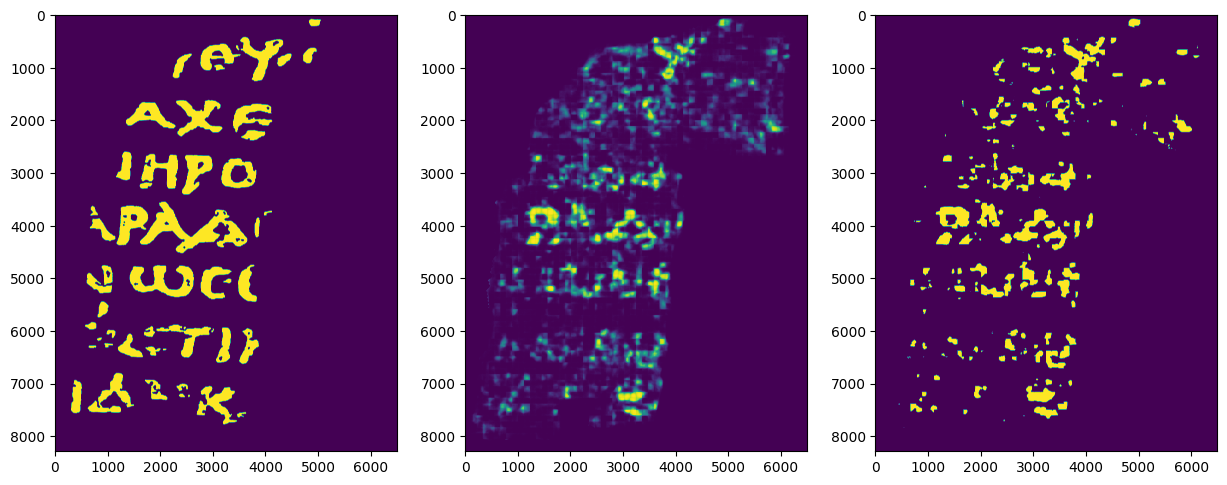

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([43349069.,  2784965.,  1579007.,  1089138.,   835203.,   630885.,
          480056.,   405883.,   352807.,   316727.,   266205.,   226069.,
          194216.,   180813.,   176803.,   163462.,   164674.,   172836.,
          215284.,   254746.]),
 array([1.30935573e-17, 4.99543846e-02, 9.99087691e-02, 1.49863154e-01,
        1.99817538e-01, 2.49771923e-01, 2.99726307e-01, 3.49680692e-01,
        3.99635077e-01, 4.49589461e-01, 4.99543846e-01, 5.49498230e-01,
        5.99452615e-01, 6.49406999e-01, 6.99361384e-01, 7.49315768e-01,
        7.99270153e-01, 8.49224538e-01, 8.99178922e-01, 9.49133307e-01,
        9.99087691e-01]),
 <BarContainer object of 20 artists>)

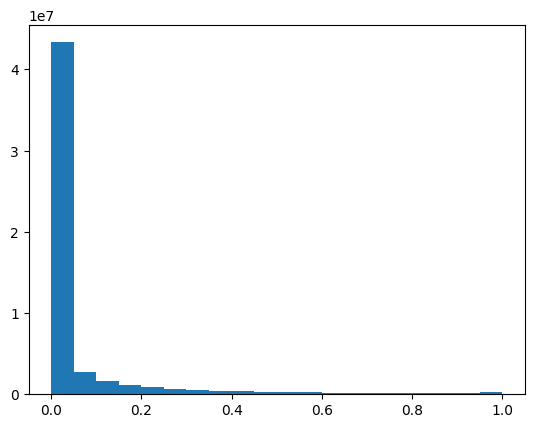

In [34]:
plt.hist(mask_pred.flatten(), bins=20)